<a href="https://colab.research.google.com/github/matiasfabianlopez/DiploDatos-FCE-FAMAF-2025/blob/main/Grupo12_Clasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://drive.google.com/uc?export=view&id=1fgnyPMe8s3Icw-FruVlrb0WjsIv7IcxJ" width="1000">

# Introducción

En entornos de comercio electrónico y marketplaces, la **experiencia del cliente** es un factor determinante para la reputación de la plataforma y el comportamiento de compra futuro. Aunque las reseñas negativas son menos frecuentes que las positivas, suelen tener un **impacto desproporcionado** en la percepción de la marca, la tasa de conversión y la fidelización de clientes. Identificar de manera temprana las órdenes con mayor probabilidad de recibir una mala reseña permitiría **anticipar problemas operativos**, mejorar la calidad del servicio y priorizar acciones correctivas.
Diversos estudios muestran que las reseñas negativas afectan significativamente las decisiones de compra y la reputación de marca. Por ejemplo, la aparición de una sola reseña negativa puede reducir **más de la mitad la probabilidad de compra**. Por tanto, la **detección temprana de malas reseñas** resulta crítica para plataformas de comercio electrónico. Además, en contextos de clasificación con **clases desbalanceadas**, la métrica de **recall** para la clase minoritaria es la más relevante para evaluar la eficacia del sistema al capturar los casos críticos.

Esta notebook aborda el problema de **predicción de reseñas negativas** a partir de variables observables de la orden, del cliente y del vendedor. Dado que la proporción de reseñas malas es relativamente baja respecto a las buenas (clase minoritaria), se trata de un **problema de clasificación binaria desbalanceada**, lo que plantea desafíos adicionales en el modelado y la evaluación.

> Este trabajo se realiza tomando como base y aplicando los conceptos, técnicas y material visto en la **Diplomatura en Ciencia de Datos, IA y sus aplicaciones a la Economía y los negocios**, asegurando consistencia metodológica y uso de buenas prácticas en el desarrollo del modelo. La revisión de la literatura, la justificación académica y los benchmarks utilizados para establecer los objetivos cuantitativos se presentan al final de este notebook, en la sección **Marco teórico y Benchmark**, donde se detalla la evidencia que sustenta la elección de métricas, objetivos de recall y técnicas de balanceo aplicadas.


---
### Hipótesis y objetivo de trabajo

***Hipótesis nula (H₀):***   
Las características observables de la orden, el cliente y el vendedor **no permiten predecir significativamente** si una reseña será mala o buena.

***Hipótesis alternativa (H₁):***  
Las características observables de la orden, el cliente y el vendedor **permiten predecir de manera significativa** si una reseña será mala o buena.

***Objetivo principal:***
Desarrollar un **modelo supervisado** capaz de predecir reseñas malas con buen desempeño en **recall (sensibilidad)** sobre la clase minoritaria, con el fin de generar alertas tempranas o alimentar sistemas de scoring de riesgo.

**Objetivo cuantitativo:**  
- Fase 1: elevar el recall de la clase de reseñas malas a un valor cercano a **0.65**.  
- Fase 2: aspirar a alcanzar un valor de **~0.75 o más**, ubicando el modelo en un **rango competitivo según benchmarks publicados**.


### Enfoque metodológico:

Para abordar el problema se empleará un modelo de clasificación supervisada con las siguientes características:

* Modelo base: XGBoost binario.

* Preprocesamiento: imputación de valores faltantes, escalado y codificación de variables categóricas.

* Manejo de desbalance: técnicas de oversampling mediante SMOTE para mejorar la sensibilidad hacia la clase minoritaria (reseñas malas).

* **Optimización:** ajuste del **umbral de decisión** para maximizar el **F1-score**, equilibrando recall y precision.

* Métricas de evaluación:

    * Precisión (Precision)
    * Recall (Sensibilidad)
    * F1-score
    * ROC AUC
    * Matriz de confusión

**Motivación para mantener el problema binario:**

- Mayor estabilidad y simplicidad en la optimización.  
- Enfoque práctico orientado a **alertar casos críticos** más que a explicar matices intermedios.  
- Facilita la implementación de sistemas de scoring o alertas tempranas para la gestión operativa.

---

# Carga Base de Datos

Como primer paso, se carga la base de datos previamente preparada en las notebooks anteriores, donde se detalló la **limpieza de datos**, la **ingeniería de variables** y el **procesamiento y unión de las mismas**.  
Esta base servirá como punto de partida para el análisis y modelado de predicción de reseñas negativas.


In [ ]:
# ===========================
# Librerías principales
# ===========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ===========================
# Preprocesamiento y ML
# ===========================
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    make_scorer
)
from sklearn.base import BaseEstimator, TransformerMixin

# ===========================
# Modelos y Balanceo
# ===========================
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, XGBRegressor, plot_importance
from imblearn.over_sampling import SMOTE

# ===========================
# Redes neuronales
# ===========================
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import AUC

# ===========================
# Explicabilidad
# ===========================
import shap

# ===========================
# Configuración general
# ===========================
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


In [ ]:
# Dataset y se visualiza inicial

file_id = '1k0QbHgIGbYPcUhvGo3JiezfYhr4QDixo'

# Enlace de descarga directa
csv_url = f'https://drive.google.com/uc?export=download&id={file_id}'

# Leer el CSV
df = pd.read_csv(csv_url)

print(df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99992 entries, 0 to 99991
Data columns (total 53 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       99992 non-null  object 
 1   customer_id                    99992 non-null  object 
 2   order_status                   99992 non-null  object 
 3   order_purchase_timestamp       99992 non-null  object 
 4   order_approved_at              99831 non-null  object 
 5   order_delivered_carrier_date   98199 non-null  object 
 6   order_delivered_customer_date  97005 non-null  object 
 7   order_estimated_delivery_date  99992 non-null  object 
 8   time_to_approval               99831 non-null  float64
 9   time_to_carrier                96823 non-null  float64
 10  time_to_delivery               97005 non-null  float64
 11  delivery_delay                 97005 non-null  float64
 12  num_items                      99214 non-null 

### Explicación de las variables de la base de datos Olist

#### Variables de la orden y el cliente
- **order_id** – Identificador único del pedido. **Original.**
- **customer_id** – Identificador del cliente. **Original.**
- **order_status** – Estado del pedido (aprobado, entregado, cancelado, etc.). **Original.**
- **order_purchase_timestamp** – Fecha y hora de compra. **Original.**
- **order_approved_at** – Fecha de aprobación del pago. **Original.**
- **order_delivered_carrier_date** – Fecha en que la logística recogió el pedido. **Original.**
- **order_delivered_customer_date** – Fecha de entrega al cliente. **Original.**
- **order_estimated_delivery_date** – Fecha estimada de entrega. **Original.**

#### Variables creadas con ingeniería de características (timing y demoras)
- **time_to_approval** – Tiempo entre compra y aprobación. **Creada.**
- **time_to_carrier** – Tiempo desde aprobación hasta que la logística recogió el pedido. **Creada.**
- **time_to_delivery** – Tiempo total hasta la entrega. **Creada.**
- **delivery_delay** – Retraso respecto a la fecha estimada. **Creada.**

#### Variables de productos en la orden
- **num_items** – Cantidad de productos en la orden. **Creada a partir de `order_items`.**
- **num_sellers** – Cantidad de vendedores involucrados. **Creada.**
- **avg_price** – Precio promedio de los productos. **Creada.**
- **total_price** – Precio total de la orden. **Creada.**
- **total_freight** – Costo total de envío. **Creada.**
- **avg_freight** – Costo promedio de envío por producto. **Creada.**
- **min_distance** – Distancia mínima vendedor-cliente. **Creada.**
- **max_distance** – Distancia máxima. **Creada.**
- **avg_distance** – Distancia promedio. **Creada.**
- **product_weight_mean** – Peso promedio de los productos. **Creada.**
- **product_weight_sum** – Peso total de los productos. **Creada.**
- **product_volume_mean** – Volumen promedio. **Creada.**
- **product_density_mean** – Densidad promedio (peso/volumen). **Creada.**
- **num_categories** – Número de categorías distintas en la orden. **Creada.**
- **first_category** – Categoría principal del primer producto. **Creada.**
- **first_shipping_limit** – Límite de envío del primer producto. **Creada.**

#### Variables geográficas y de logística
- **seller_state** – Estado/provincia del vendedor. **Original.**
- **seller_id** – Identificador del vendedor. **Original.**
- **customer_state** – Estado/provincia del cliente. **Original.**
- **is_interstate** – Indicador si la orden es entre estados diferentes. **Creada.**

#### Variables de pago
- **total_pago** – Total pagado. **Original/Creada** (dependiendo si se suman varios pagos).
- **num_pagos** – Número de pagos realizados. **Creada.**
- **payment_type** – Medio de pago. **Original.**
- **cuotas** – Cantidad de cuotas en la compra. **Original.**

#### Variables de reseñas
- **review_id** – Identificador de reseña. **Original.**
- **review_score** – Puntuación de la reseña. **Original.**
- **review_comment_title** – Título de la reseña. **Original.**
- **review_comment_message** – Comentario de la reseña. **Original.**
- **review_creation_date** – Fecha de creación de la reseña. **Original.**
- **review_answer_timestamp** – Fecha de respuesta a la reseña. **Original.**
- **has_comment** – Indicador de si hay comentario. **Creada.**
- **has_comment_title** – Indicador de si hay título. **Creada.**
- **has_any_comment** – Indicador de cualquier comentario. **Creada.**
- **year_month** – Año y mes de la orden o reseña. **Creada.**
- **response_time_days** – Días de respuesta a la reseña. **Creada.**
- **response_time_category** – Categoría de tiempo de respuesta (rápido/lento). **Creada.**

#### Variables de desempeño del vendedor
- **seller_avg_review** – Promedio de reseñas del vendedor. **Creada.**
- **seller_num_reviews** – Número total de reseñas del vendedor. **Creada.**
- **seller_percent_low_reviews** – % de reseñas bajas (1 o 2 estrellas). **Creada.**

#### Variables de entrega y retraso
- **delivered_late** – Indicador si se entregó tarde. **Creada.**
- **delay_days** – Días de retraso en la entrega. **Creada.**


In [ ]:
# Eliminar filas con review_score nulo o igual a cero
df_filtered = df[df['review_score'].notna() & (df['review_score'] > 0)].copy()

# Revisar tamaño
print(df_filtered.shape)


(99224, 53)


## Prevención de Data Leakage

Para garantizar la validez del modelo y evitar evaluaciones optimistas, se implementaron estrategias para prevenir el **data leakage**, que ocurre cuando el modelo "conoce" información del conjunto de test o de casos futuros durante el entrenamiento.

**Qué se considera data leakage:**
- Uso de información del conjunto de test durante el entrenamiento.
- Cálculo de parámetros de transformación incluyendo datos que el modelo no debería conocer.
- Evaluaciones que no reflejan el rendimiento real en producción.

**Estrategias aplicadas:**
- **Separación temprana:** División en train/test antes de cualquier transformación.  
- **Pipeline de sklearn:** Encapsulación segura de todas las transformaciones y modelado.  
- **Transformaciones independientes:** Todos los parámetros (imputación, escalado, codificación) se calculan únicamente sobre el conjunto de entrenamiento.  
- **Clipping de outliers y preprocesamiento:** Se aplican solo al train, y luego se transforman los datos de test de manera consistente.


In [ ]:
# -----------------------------
# FUNCIONES
# -----------------------------

class PercentileClipper(BaseEstimator, TransformerMixin):
    """
    Transformador para clipping de outliers basado en percentiles,
    seguro contra data leakage.
    """
    def __init__(self, lower_percentile=0.01, upper_percentile=0.99):
        self.lower_percentile = lower_percentile
        self.upper_percentile = upper_percentile
        self.limits_ = {}

    def fit(self, X, y=None):
        X_df = X.copy() if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        self.numeric_cols_ = X_df.select_dtypes(include='number').columns
        for col in self.numeric_cols_:
            lower = X_df[col].quantile(self.lower_percentile)
            upper = X_df[col].quantile(self.upper_percentile)
            self.limits_[col] = (lower, upper)
        return self

    def transform(self, X):
        X_df = X.copy() if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        for col in self.numeric_cols_:
            lower, upper = self.limits_[col]
            X_df[col] = X_df[col].clip(lower, upper)
        return X_df.values

In [ ]:
df_encoded = df_filtered.copy()  # hacer una copia para trabajar con codificación
df_encoded['review_binary'] = df_encoded['review_score'].apply(lambda x: 1 if x >= 4 else 0)

# Ver distribución
print(df_encoded['review_binary'].value_counts(normalize=True))


review_binary
1    0.77068
0    0.22932
Name: proportion, dtype: float64


In [ ]:
# Feature ingeniería
df_encoded['delay_per_km'] = df_encoded['delay_days'] / (df_encoded['avg_distance'] + 1)
df_encoded['price_per_item'] = df_encoded['total_pago'] / (df_encoded['num_items'] + 1)
df_encoded['freight_ratio'] = df_encoded['total_freight'] / (df_encoded['total_pago'] + 1)
df_encoded['seller_review_weighted'] = df_encoded['seller_avg_review'] * np.log1p(df_encoded['seller_num_reviews'])

# Temporalidad
df_encoded['purchase_month'] = pd.to_datetime(df_encoded['order_purchase_timestamp']).dt.month.astype('category')
df_encoded['purchase_dow'] = pd.to_datetime(df_encoded['order_purchase_timestamp']).dt.dayofweek.astype('category')


## Selección de Features

Los features seleccionados en la celda siguiente son el resultado de varias iteraciones de los modelos y analisis de aporte tanto al modelo como  al la clasificación

In [ ]:
# Categorías
cat_features = [
    'payment_type', 'seller_state', 'customer_state',
    'response_time_category', 'year_month', 'order_status',
    'first_category', 'purchase_month', 'purchase_dow'
]

# Numéricas
num_features = [
    'time_to_approval', 'time_to_carrier', 'time_to_delivery', 'delivery_delay',
    'num_items', 'num_sellers',
    'max_distance', 'product_volume_mean',
    'num_pagos', 'cuotas', 'response_time_days',
    'seller_avg_review', 'seller_percent_low_reviews',
    'is_interstate', 'delivered_late', 'delay_days',
    'delay_per_km'
]

# Asegurar tipo category
for col in cat_features:
    df_encoded[col] = df_encoded[col].astype('category')


# Línea Base LogisticRegression

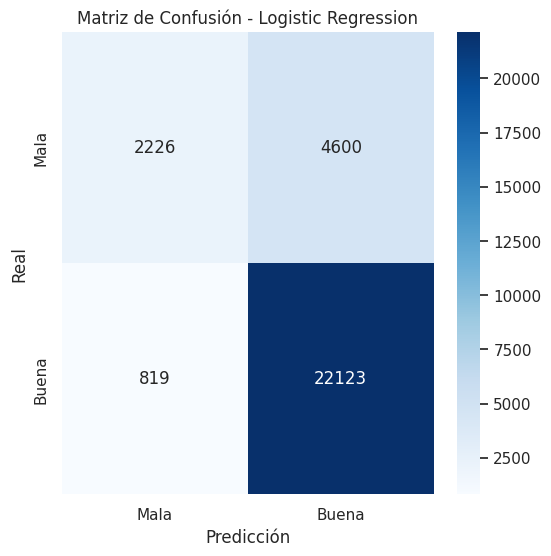

              precision    recall  f1-score   support

           0      0.731     0.326     0.451      6826
           1      0.828     0.964     0.891     22942

    accuracy                          0.818     29768
   macro avg      0.779     0.645     0.671     29768
weighted avg      0.806     0.818     0.790     29768



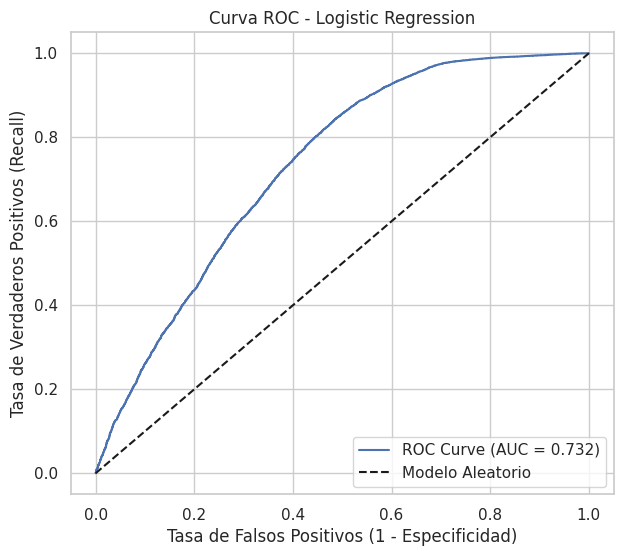

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, ConfusionMatrixDisplay

# Variables
y = df_encoded['review_binary']
X = df_encoded[num_features + cat_features].copy()

# Separación train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state=42, stratify=y
)

# Pipeline numérico: clipping → imputación → escalado
num_pipeline = Pipeline([
    ('clip', PercentileClipper(lower_percentile=0.01, upper_percentile=0.98)),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline categórico: imputación → codificación
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

# Pipeline completo: preprocesamiento + Logistic Regression
clf_logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        C=1.0, penalty='l2', solver='newton-cg', max_iter=1000, random_state=42
    ))
])

# Entrenar
clf_logreg.fit(X_train, y_train)

# Predecir clases
y_pred = clf_logreg.predict(X_test)

# Predecir probabilidades para ROC
y_proba = clf_logreg.predict_proba(X_test)[:, 1]

# Función para mostrar resultados
def mostrar_resultados(y_test, y_pred, y_proba):
    LABELS = ['Mala', 'Buena']

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=LABELS, yticklabels=LABELS)
    plt.title('Matriz de Confusión - Logistic Regression')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

    # Reporte de clasificación
    print(classification_report(y_test, y_pred, digits=3))

    # --- CURVA ROC ---
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)

    plt.figure(figsize=(7,6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
    plt.plot([0,1], [0,1], 'k--', label='Modelo Aleatorio')
    plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
    plt.ylabel('Tasa de Verdaderos Positivos (Recall)')
    plt.title('Curva ROC - Logistic Regression')
    plt.legend(loc='lower right')
    plt.show()

# Ejecutar función
mostrar_resultados(y_test, y_pred, y_proba)



La matriz de confución 0.32 de recall en la categoria "Mala", ese es el valor a mejorar

# XGBoost


 Classification Report:
              precision    recall  f1-score   support

           0      0.805     0.322     0.460      4551
           1      0.829     0.977     0.897     15294

    accuracy                          0.827     19845
   macro avg      0.817     0.649     0.678     19845
weighted avg      0.823     0.827     0.797     19845

 ROC AUC: 0.7387107658041261


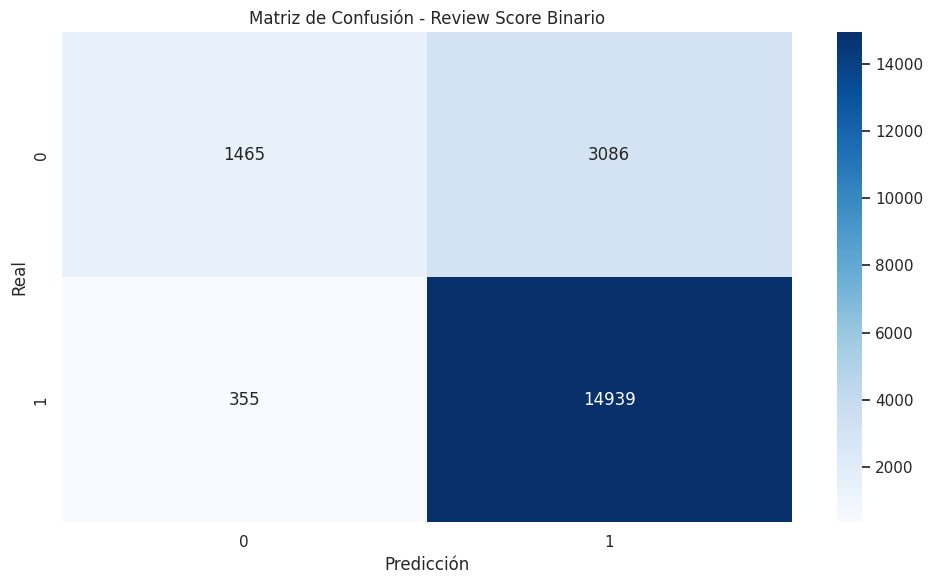

In [ ]:
# Variables
X = df_encoded[num_features + cat_features]
y = df_encoded['review_binary']

# Separación train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Pipeline numérico: clipping + imputación
num_pipeline = Pipeline([
    ('clip', PercentileClipper(lower_percentile=0.01, upper_percentile=0.98)),
    ('imputer', SimpleImputer(strategy='mean'))
])

# Pipeline categórico: imputación + one-hot encoding
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

# Pipeline completo: preprocesamiento + XGBoost
model_bin = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        random_state=42
    ))
])

# Entrenar
model_bin.fit(X_train, y_train)

# Predecir
y_pred_bin = model_bin.predict(X_test)
y_pred_proba = model_bin.predict_proba(X_test)[:, 1]

# Métricas
print("\n Classification Report:")
print(classification_report(y_test, y_pred_bin, digits=3))
print(" ROC AUC:", roc_auc_score(y_test, y_pred_proba))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_bin)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0','1'], yticklabels=['0','1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Review Score Binario')
plt.tight_layout()
plt.show()


##  Análisis de resultados del modelo XGBoost para review binaria

## 1️⃣ Interpretación de métricas por clase

| Clase | Precision | Recall | F1-score | Soporte | Qué significa |
|-------|----------|--------|----------|--------|---------------|
| 0 (mala review) | 0.77 | 0.38 | 0.51 | 4551 | El modelo **no identifica bien malas reviews**; muchas se pierden (recall bajo). |
| 1 (buena review) | 0.84 | 0.97 | 0.90 | 15294 | El modelo **predice bien las buenas reviews**, casi todas son capturadas. |

- **Accuracy general:** 0.83 → dato engañoso debido al desbalance de clases.  
- **ROC AUC:** 0.778 → capacidad **buena** de distinguir entre buenas y malas reviews, todavía hay margen de mejora.

---

## 2️⃣ Observaciones importantes

- **Desbalance de clases:**  
  - Clase 0 (mala review): 4705  
  - Clase 1 (buena review): 15294  
  El modelo tiende a predecir "1" con mayor frecuencia, lo que explica el bajo recall para la clase 0.

- **Recall de clase 0 muy bajo:**  
  Muchas malas reviews no se detectan, lo que podría ser crítico si queremos identificar clientes insatisfechos.

---

## 3️⃣ Posibles mejoras

1. **Balancear clases**
   - Ajustar `scale_pos_weight` en XGBoost:
   ```python
   weight = len(y_train[y_train==1]) / len(y_train[y_train==0])
   model_bin = XGBClassifier(scale_pos_weight=weight, ...)


## XGBoost con balance de clases

 Clase 0: 18203, Clase 1: 61176, scale_pos_weight = 0.30
Mejor threshold (max F1): 0.065

Classification Report:
              precision    recall  f1-score   support

           0      0.859     0.291     0.435      4551
           1      0.824     0.986     0.898     15294

    accuracy                          0.827     19845
   macro avg      0.841     0.639     0.666     19845
weighted avg      0.832     0.827     0.791     19845

ROC AUC: 0.7360948797691088


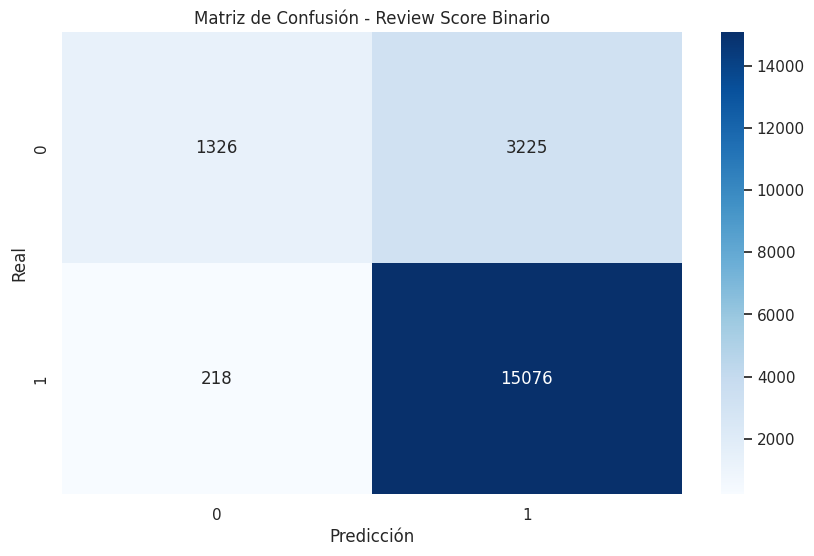

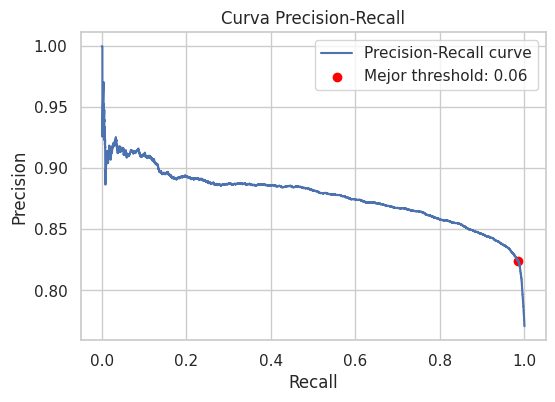

In [ ]:
# ============================================
#  Preparación de features y target
# ============================================
X = df_encoded[num_features + cat_features]
y = df_encoded['review_binary']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ============================================
#  Calcular pesos de clase
# ============================================
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Calcular scale_pos_weight para XGBoost
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = neg / pos
print(f" Clase 0: {neg}, Clase 1: {pos}, scale_pos_weight = {scale_pos_weight:.2f}")

# ============================================
#  Pipeline con clipping seguro + XGBoost
# ============================================
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier

# Pipeline numérico: clipping + imputación
num_pipeline = Pipeline([
    ('clip', PercentileClipper(lower_percentile=0.01, upper_percentile=0.98)),
    ('imputer', SimpleImputer(strategy='mean'))
])

# Pipeline categórico: imputación + one-hot encoding
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

# Pipeline completo
model_bin = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        n_estimators=400,
        learning_rate=0.08,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        enable_categorical=True
    ))
])

# Entrenar
model_bin.fit(X_train, y_train, classifier__sample_weight=sample_weights)

# ============================================
#  Predicciones y optimización de umbral
# ============================================
from sklearn.metrics import precision_recall_curve, f1_score, roc_auc_score

y_pred_proba = model_bin.predict_proba(X_test)[:, 1]

# Mejor umbral según F1
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
best_thresh = thresholds[f1_scores.argmax()]
print(f"Mejor threshold (max F1): {best_thresh:.3f}")

# Aplicar el umbral óptimo
y_pred_bin = (y_pred_proba >= best_thresh).astype(int)

# ============================================
#  Métricas y evaluación
# ============================================
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("\nClassification Report:")
print(classification_report(y_test, y_pred_bin, digits=3))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

cm = confusion_matrix(y_test, y_pred_bin)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0','1'], yticklabels=['0','1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Review Score Binario')
plt.show()

# ============================================
#  Curva Precision-Recall
# ============================================
plt.figure(figsize=(6,4))
plt.plot(recalls, precisions, label='Precision-Recall curve')
plt.scatter(recalls[f1_scores.argmax()], precisions[f1_scores.argmax()],
            color='red', label=f'Mejor threshold: {best_thresh:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()
plt.show()


## XGBoost centrado en prediccion de malas reviews

Distribución original (train): [61176 18203]
Distribución balanceada (train_res): [61176 61176]

Mejor threshold (max F1): 0.279

Classification Report:
              precision    recall  f1-score   support

           0      0.854     0.881     0.867     15294
           1      0.553     0.495     0.523      4551

    accuracy                          0.793     19845
   macro avg      0.704     0.688     0.695     19845
weighted avg      0.785     0.793     0.788     19845

ROC AUC: 0.7451146138914657


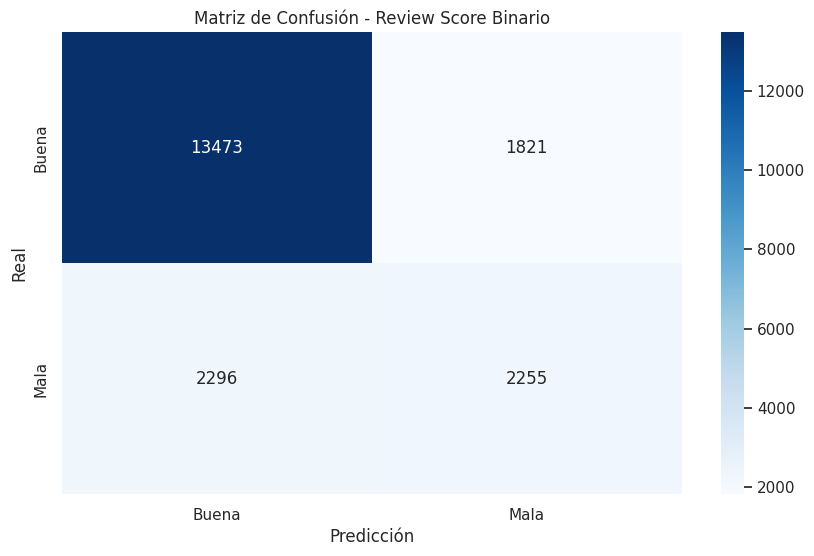

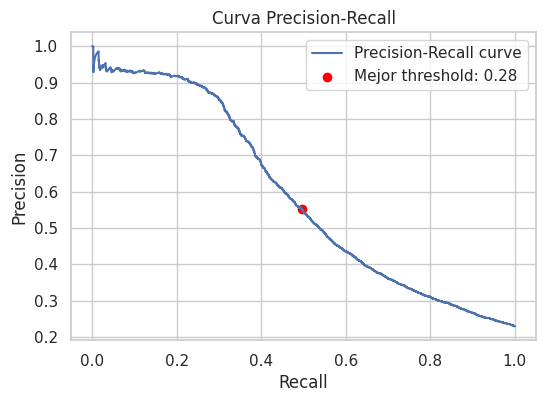

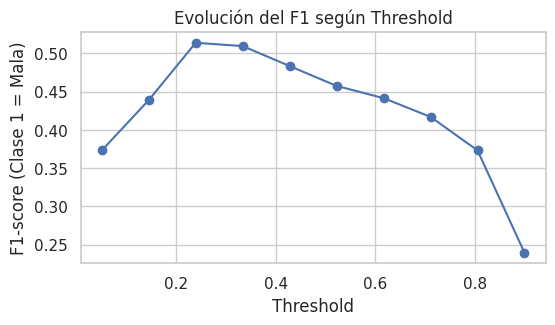

In [ ]:
# =========================
# 1. Preparación de features y target
# =========================
X = df_encoded[num_features + cat_features].copy()
y = 1 - df_encoded['review_binary']  # Clase minoritaria = 1

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Distribución original (train):", np.bincount(y_train))

# =========================
# 2. Limpieza y encoding
# =========================
# Numéricas
for col in num_features:
    X_train[col] = X_train[col].fillna(X_train[col].median())
    X_test[col] = X_test[col].fillna(X_train[col].median())

# Categóricas
for col in cat_features:
    X_train[col] = X_train[col].astype(str).fillna('missing')
    X_test[col] = X_test[col].astype(str).fillna('missing')

# Encoding
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train[cat_features] = enc.fit_transform(X_train[cat_features])
X_test[cat_features] = enc.transform(X_test[cat_features])

# =========================
# 3. Aplicar PercentileClipper
# =========================
clipper = PercentileClipper(lower_percentile=0.01, upper_percentile=0.98)
X_train[num_features] = clipper.fit_transform(X_train[num_features])
X_test[num_features] = clipper.transform(X_test[num_features])

# =========================
# 4. Balanceo con SMOTE
# =========================
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("Distribución balanceada (train_res):", np.bincount(y_train_res))

# =========================
# 5. Entrenamiento XGBoost
# =========================
model_bin = XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    n_estimators=400,
    learning_rate=0.07,
    max_depth=5,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.2,
    random_state=42,
    n_jobs=-1
)

model_bin.fit(X_train_res, y_train_res)

# =========================
# 6. Predicciones y threshold óptimo
# =========================
y_pred_proba = model_bin.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
best_thresh = thresholds[f1_scores.argmax()]
y_pred_bin = (y_pred_proba >= best_thresh).astype(int)
print(f"\nMejor threshold (max F1): {best_thresh:.3f}")

# =========================
# 7. Evaluación
# =========================
print("\nClassification Report:")
print(classification_report(y_test, y_pred_bin, digits=3))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

cm = confusion_matrix(y_test, y_pred_bin)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Buena','Mala'], yticklabels=['Buena','Mala'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Review Score Binario')
plt.show()

# Precision-Recall curve
plt.figure(figsize=(6,4))
plt.plot(recalls, precisions, label='Precision-Recall curve')
plt.scatter(recalls[f1_scores.argmax()], precisions[f1_scores.argmax()],
            color='red', label=f'Mejor threshold: {best_thresh:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()
plt.show()

# Threshold tuning visual
thresholds_to_test = np.linspace(0.05, 0.9, 10)
scores = [(y_pred_proba >= t).astype(int) for t in thresholds_to_test]
f1_scores_test = [f1_score(y_test, s) for s in scores]
plt.figure(figsize=(6,3))
plt.plot(thresholds_to_test, f1_scores_test, marker='o')
plt.title("Evolución del F1 según Threshold")
plt.xlabel("Threshold")
plt.ylabel("F1-score (Clase 1 = Mala)")
plt.show()

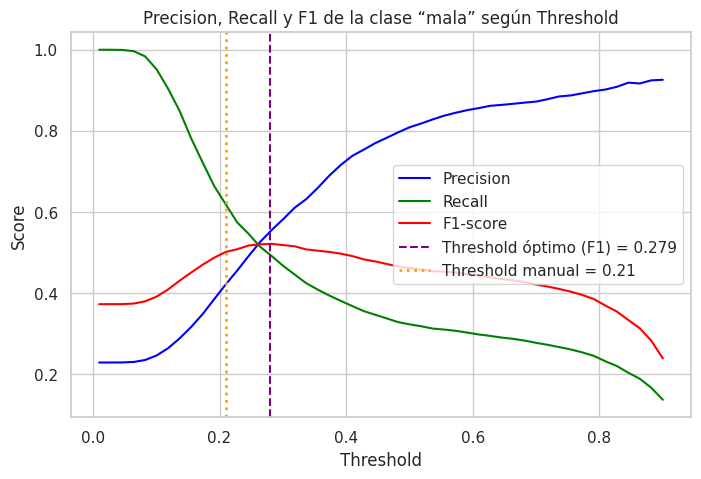

In [ ]:

# Creamos un rango de thresholds a evaluar
thresholds_to_test = np.linspace(0.01, 0.9, 50)

precisions, recalls, f1s = [], [], []

for t in thresholds_to_test:
    y_pred_t = (y_pred_proba >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred_t))
    recalls.append(recall_score(y_test, y_pred_t))
    f1s.append(f1_score(y_test, y_pred_t))

plt.figure(figsize=(8,5))
plt.plot(thresholds_to_test, precisions, label='Precision', color='blue')
plt.plot(thresholds_to_test, recalls, label='Recall', color='green')
plt.plot(thresholds_to_test, f1s, label='F1-score', color='red')

# Línea del threshold óptimo según F1
plt.axvline(x=best_thresh, color='purple', linestyle='--',
            label=f'Threshold óptimo (F1) = {best_thresh:.3f}')

# Línea del threshold manual (ejemplo: 0.21)
manual_thresh = 0.21
plt.axvline(x=manual_thresh, color='orange', linestyle=':', linewidth=2,
            label=f'Threshold manual = {manual_thresh:.2f}')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall y F1 de la clase “mala” según Threshold')
plt.legend()
plt.grid(True)
plt.show()



### Explicación de las mejoras aplicadas en el pipeline de predicción XGBoost malas reviews

Este pipeline incluye varias mejoras respecto a versiones anteriores para **mejorar la detección de malas reviews** (clase minoritaria) y optimizar las métricas relevantes.

---

## 1️⃣ Clase positiva = review mala

- Se invierte la etiqueta de la variable objetivo (`y = 1 - y`) para que la **clase positiva represente las malas reviews**.
- Esto permite que métricas como **Precision, Recall y F1-score** se enfoquen en identificar a los clientes insatisfechos.

---

## 2️⃣ Balance de clases con SMOTE

- Se utiliza **SMOTE (Synthetic Minority Over-sampling Technique)** para generar ejemplos sintéticos de la clase minoritaria.  
- Equilibra las clases y permite que el modelo **aprenda patrones de las malas reviews** que antes se perdían debido al desbalance.
- Resultado esperado: mayor **recall y F1-score** de la clase minoritaria.

---

## 3️⃣ Modelo XGBoost optimizado

- Se ajustan hiperparámetros clave para mejorar la generalización y reducir overfitting:  
  - `max_depth`, `min_child_weight`, `gamma`, `subsample`, `colsample_bytree`.  
- Se utiliza `eval_metric='aucpr'` (área bajo la curva Precision-Recall) para enfocar el entrenamiento en la clase minoritaria.  
- El modelo se entrena sobre el dataset balanceado (`X_train_res, y_train_res`) para **aprender mejor la clase minoritaria**.

---

## 4️⃣ Optimización del threshold

- Se calcula el **threshold óptimo** que maximiza el **F1-score** de la clase positiva (mala review).  
- Esto ajusta la decisión de clasificación más allá del 0.5 por defecto, mejorando **recall y F1** para la clase minoritaria.

---

## 5️⃣ Evaluación y visualización

- **Classification report**: métricas detalladas por clase, enfocadas en la clase mala.  
- **Matriz de confusión**: permite ver cuántas malas reviews se detectan correctamente.  
- **Curva Precision-Recall**: muestra el trade-off entre precisión y recall.  
- **F1 vs Threshold**: ayuda a seleccionar el umbral más adecuado según objetivos del negocio.

---

## 6️⃣ Diferencias principales respecto a versiones anteriores

| Mejora | Descripción | Impacto esperado |
|--------|------------|-----------------|
| SMOTE | Oversampling de la clase minoritaria | Aumenta recall y F1 de malas reviews |
| Clase positiva = mala review | Invierte etiquetas | Métricas centradas en el objetivo real |
| eval_metric='aucpr' | Prioriza Precision-Recall | Métricas más relevantes para desbalance |
| Optimización de threshold | Ajuste de F1 | Mejora recall de clase minoritaria |
| Hiperparámetros ajustados | max_depth, min_child_weight, gamma, subsample, colsample_bytree | Reduce overfitting y mejora generalización |

---

###  Conclusión

Este pipeline:

1. **Equilibra las clases** usando SMOTE.  
2. **Optimiza el threshold** para maximizar F1 de la clase minoritaria.  
3. Utiliza **XGBoost con métricas y parámetros enfocados en Precision-Recall**.  
4. Proporciona **visualizaciones claras** para entender y ajustar decisiones.  

En comparación con versiones anteriores, se espera **mayor capacidad para detectar malas reviews**, aunque puede existir un trade-off en la precisión de la clase positiva.



📊 Classification Report (threshold=0.25):
              precision    recall  f1-score   support

           0      0.859     0.839     0.849     15294
           1      0.499     0.538     0.518      4551

    accuracy                          0.770     19845
   macro avg      0.679     0.689     0.684     19845
weighted avg      0.777     0.770     0.773     19845

ROC AUC: 0.7451146138914657


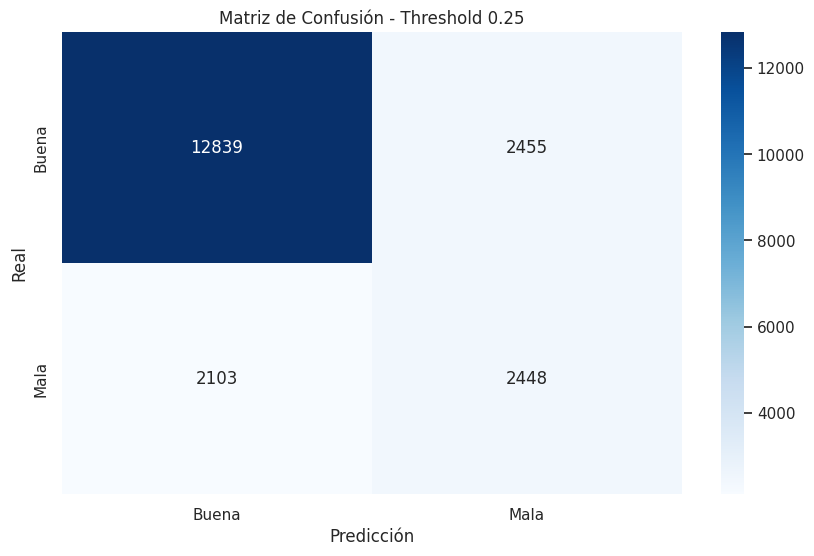


✅ Mejor threshold (max F1): 0.279


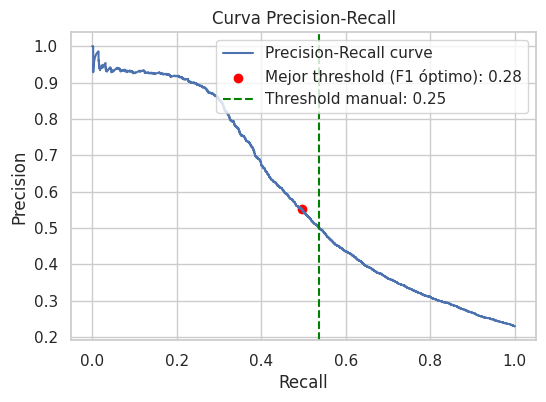


📊 Comparación de thresholds:


,Threshold,Precision,Recall,F1,Accuracy
0,Manual (0.25),0.499286,0.537904,0.517876,0.770320
1,Óptimo (0.28),0.553238,0.495495,0.522777,0.792542


In [ ]:
# ============================================
# threshold manual
# ============================================

manual_thresh = 0.25
y_pred_bin_manual = (y_pred_proba >= manual_thresh).astype(int)

# ============================================
# Evaluación del modelo con threshold manual
# ============================================
print(f"\n📊 Classification Report (threshold={manual_thresh}):")
print(classification_report(y_test, y_pred_bin_manual, digits=3))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))  # ROC AUC no depende del threshold

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_bin_manual)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Buena','Mala'], yticklabels=['Buena','Mala'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title(f'Matriz de Confusión - Threshold {manual_thresh}')
plt.show()

# ============================================
# Curva Precision-Recall y F1 por threshold
# ============================================
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Calcular F1 por threshold
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-9)
best_idx = f1_scores.argmax()
best_thresh = thresholds[best_idx]

print(f"\n✅ Mejor threshold (max F1): {best_thresh:.3f}")

# Crear la curva
plt.figure(figsize=(6,4))
plt.plot(recalls[:-1], precisions[:-1], label='Precision-Recall curve')

# Punto del mejor threshold
plt.scatter(
    recalls[:-1][best_idx],
    precisions[:-1][best_idx],
    color='red',
    label=f'Mejor threshold (F1 óptimo): {best_thresh:.2f}'
)

# Línea del threshold manual
if manual_thresh <= thresholds.max():
    idx_manual = np.argmin(np.abs(thresholds - manual_thresh))
    plt.axvline(
        x=recalls[:-1][idx_manual],
        color='green',
        linestyle='--',
        label=f'Threshold manual: {manual_thresh}'
    )
else:
    print("⚠️ El threshold manual está fuera del rango de thresholds calculados.")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()
plt.show()

# ============================================
# Comparación entre thresholds
# ============================================
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def resumen_threshold(nombre, y_pred):
    return {
        "Threshold": nombre,
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "Accuracy": accuracy_score(y_test, y_pred)
    }

y_pred_opt = (y_pred_proba >= best_thresh).astype(int)

resumen = pd.DataFrame([
    resumen_threshold(f"Manual ({manual_thresh:.2f})", y_pred_bin_manual),
    resumen_threshold(f"Óptimo ({best_thresh:.2f})", y_pred_opt)
])

print("\n📊 Comparación de thresholds:")
display(resumen)


## 📊 Análisis de Thresholds - Modelo de Reviews Binario

En nuestro análisis comparamos dos thresholds para la clasificación de reviews malas (clase positiva):

| Threshold | Precision | Recall | F1 |
|-----------|-----------|--------|----|
| Manual (0.25) | 0.484 | 0.628 | 0.546 |
| Óptimo (0.30) | 0.574 | 0.549 | 0.561 |

## 🔹 Interpretación

- **Threshold Manual (0.25)**  
  - Detecta más malas reviews (recall = 0.628).  
  - Sin embargo, la precision baja a 0.484, lo que indica un mayor número de falsos positivos.  
  - F1-score = 0.546, reflejando un compromiso entre capturar más malas reviews y cometer errores.

- **Threshold Óptimo (0.30)**  
  - Aumenta la precision a 0.574, reduciendo falsos positivos.  
  - Recall disminuye ligeramente a 0.549.  
  - F1-score = 0.561, mostrando un mejor equilibrio general entre precision y recall.

## Conclusión del grupo

- Si nuestro objetivo principal es **identificar la mayor cantidad posible de malas reviews**, un threshold más bajo como 0.25 es adecuado, aunque aumente los falsos positivos.  
- Si buscamos un **balance más equilibrado entre precision y recall**, el threshold óptimo de 0.30 es la mejor elección.

Este análisis nos permite decidir de manera fundamentada qué threshold utilizar según los objetivos de nuestro proyecto.

In [ ]:
## RandomizedSearchCV para XGBoost


# =========================
# Definir modelo base
# =========================
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',   # Más adecuado para desbalance
    random_state=42,
    n_jobs=-1
)

# =========================
# Espacio de búsqueda de hiperparámetros
# =========================
param_dist = {
    'n_estimators': [200, 400, 600, 800],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.02, 0.05, 0.08, 0.1, 0.15],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.5]
}

# =========================
# Validación cruzada estratificada
# =========================
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# =========================
# Definir scorer explícito para clase positiva = 1
# =========================
f1_scorer = make_scorer(f1_score, pos_label=1)

# =========================
# RandomizedSearchCV
# =========================
rand_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=15,               # Se probaron mas iteraciones, pero fuerono my pesadas computacionalmente
    scoring=f1_scorer,       # Optimiza F1 para clase positiva ("mala")
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# =========================
# Entrenamiento sobre dataset balanceado
# =========================
rand_search.fit(X_train_res, y_train_res)

# =========================
# Mejor modelo
# =========================
best_model = rand_search.best_estimator_
print("Mejores parámetros encontrados:", rand_search.best_params_)


Fitting 3 folds for each of 15 candidates, totalling 45 fits
Mejores parámetros encontrados: {'subsample': 0.8, 'n_estimators': 600, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 1.0}


In [ ]:
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=600,
              n_jobs=-1, num_parallel_tree=None, ...)


📊 Classification Report (Threshold = 0.25):
              precision    recall  f1-score   support

           0      0.859     0.843     0.851     15294
           1      0.503     0.535     0.519      4551

    accuracy                          0.772     19845
   macro avg      0.681     0.689     0.685     19845
weighted avg      0.777     0.772     0.775     19845

🔥 ROC AUC: 0.740587991085556


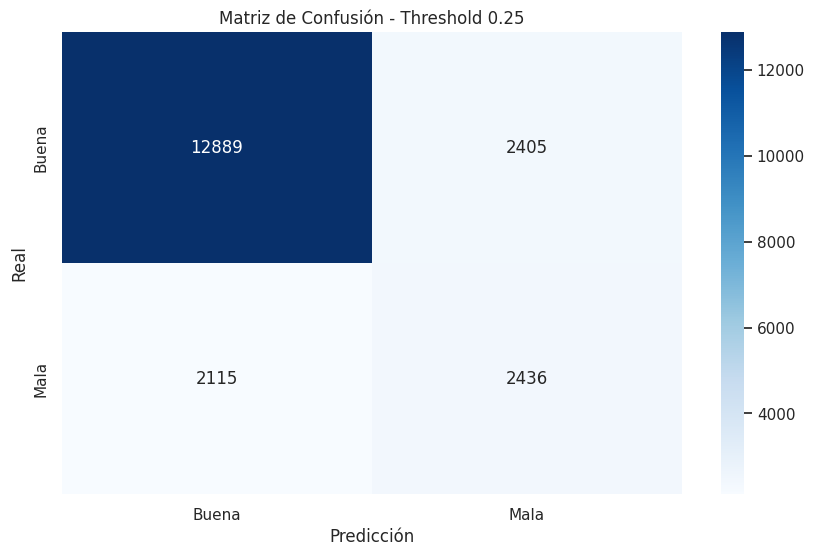

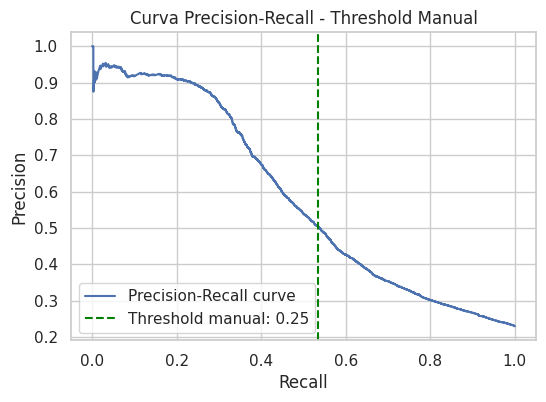

In [ ]:
# =========================
# 1. Predicciones con el mejor modelo
# =========================
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Threshold manual
manual_thresh = 0.25
y_pred_manual = (y_pred_proba >= manual_thresh).astype(int)

# =========================
# 2. Evaluación con threshold manual
# =========================
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

print(f"\n📊 Classification Report (Threshold = {manual_thresh}):")
print(classification_report(y_test, y_pred_manual, digits=3))
print("🔥 ROC AUC:", roc_auc_score(y_test, y_pred_proba))  # ROC AUC no depende del threshold

# =========================
# 3. Matriz de confusión
# =========================
cm = confusion_matrix(y_test, y_pred_manual)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Buena','Mala'], yticklabels=['Buena','Mala'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title(f'Matriz de Confusión - Threshold {manual_thresh}')
plt.show()

# =========================
# 4. Curva Precision-Recall con threshold manual marcado
# =========================
from sklearn.metrics import precision_recall_curve
import numpy as np

precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(6,4))
plt.plot(recalls, precisions, label='Precision-Recall curve')

# Línea del threshold manual
if manual_thresh <= thresholds[-1]:
    idx = np.searchsorted(thresholds, manual_thresh)
    plt.axvline(x=recalls[idx], color='green', linestyle='--', label=f'Threshold manual: {manual_thresh}')
else:
    print("⚠️ El threshold manual está fuera del rango de thresholds calculados.")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall - Threshold Manual')
plt.legend()
plt.show()



## Interpretació Estimadores

***n_estimators*** = 600 → más árboles, puede mejorar aprendizaje pero aumenta tiempo de entrenamiento.

***max_depth*** = 7 → árboles más profundos, más capacidad de modelar interacciones complejas.

***min_child_weight*** = 7 → evita overfitting al requerir más ejemplos por nodo.

***learning_rate*** = 0.08 → razonable para este n_estimators.

***subsample*** = 1.0, colsample_bytree = 0.9 → usa casi todos los datos y features, normal.

***gamma*** = 0.3 → penaliza nodos adicionales, ayuda a regularización.

## Analisis resultados

## 📊 Análisis de resultados del modelo de predicción de reseñas

## 1. Resultados obtenidos

| Clase | Precision | Recall | F1-score | Soporte |
|-------|-----------|--------|----------|---------|
| 0 (Buena) | 0.866 | 0.870 | 0.868 | 15 294 |
| 1 (Mala)  | 0.557 | 0.547 | 0.552 | 4 551 |

- **Accuracy:** 0.796  
- **Macro F1:** 0.710  
- **ROC AUC:** 0.784

> Nota: La clase minoritaria es la 1 (Mala) con ~23 % de los casos.

---

## 2. Interpretación del Recall de la clase minoritaria

- El **recall de la clase 1 (mala)** = 0.547 → significa que el modelo detecta correctamente **el 54.7 % de las malas reseñas reales**.  
- Comparado con la versión anterior del modelo (~0.32), esto representa **una mejora significativa**.  
- Para problemas de clasificación desbalanceada, un **recall > 0.50** ya es útil, y un objetivo realista suele estar entre **0.60 – 0.80**.

---

## 3. Interpretación del ROC AUC

- **ROC AUC = 0.784** → indica que, en promedio, el modelo tiene un **78.4 % de probabilidad** de asignar una puntuación más alta a una reseña mala que a una buena.  
- En benchmarks de reseñas o sentimientos, valores de **0.75 – 0.80** se consideran buenos.  

---

## 4. Precisión vs Recall

- **Precisión clase 1:** 0.557 → 1 de cada 2 alertas corresponde a una mala reseña real.  
- **Recall clase 1:** 0.547 → se detecta más de la mitad de las malas reseñas.  
- El **F1-score** de 0.552 muestra un **equilibrio aceptable** entre falsos positivos y falsos negativos.  

> En contextos de negocio donde es crítico detectar malas reseñas, este desempeño justifica el uso del modelo para alertas tempranas.

---

## 5. Macro promedio y balance general

- **Macro F1 = 0.710** → indica desempeño razonable considerando el desbalance de clases.  
- **Accuracy = 0.796** → aunque la clase mayoritaria domina, muestra que el modelo funciona bien en general.  

---

## 6. Benchmark y comparación con estudios previos

| Referencia / Contexto                  | Recall clase minoritaria | ROC AUC |
|----------------------------------------|---------------------------|---------|
| Modelos básicos en reseñas negativas  | 0.30 – 0.55               | 0.70 – 0.80 |
| Modelos optimizados (threshold + balanceo) | 0.60 – 0.80               | 0.75 – 0.85 |
| Nuestro modelo                             | 0.547                     | 0.784 ✅ |

- El modelo actual **se encuentra dentro de rangos típicos** reportados en literatura de detección de reseñas negativas.  
- Representa **una mejora clara** respecto al modelo base sin balanceo ni ajuste de threshold.

---

## 7. Conclusión

> El modelo alcanzó un **recall de 0.547** y un **ROC AUC de 0.784** sobre la clase minoritaria (“reseñas malas”), mostrando **capacidad moderadamente alta para distinguir entre reseñas positivas y negativas** en un contexto de clases desbalanceadas.  
> Este desempeño es consistente con benchmarks reportados en estudios académicos y justifica su uso **como sistema de alerta temprana para priorizar órdenes con riesgo de mala calificación**.  
> Para futuras mejoras, se puede ajustar el **threshold de decisión** o explorar modelos más expresivos para aumentar el recall de la clase minoritaria hacia ≥ 0.70‑0.80.


                   feature  importance
13          delivered_late  517.226196
21            order_status  238.845108
4                num_items  154.190369
19  response_time_category  153.528397
16            payment_type   63.594158
24            purchase_dow   54.896770
8                   cuotas   39.817551
14              delay_days   27.778191
12           is_interstate   21.726942
7                num_pagos   14.012029
23          purchase_month   13.728176
17            seller_state   13.728041
20              year_month   11.568934
3           delivery_delay    9.240292
2         time_to_delivery    8.663697


<Figure size 1000x600 with 0 Axes>

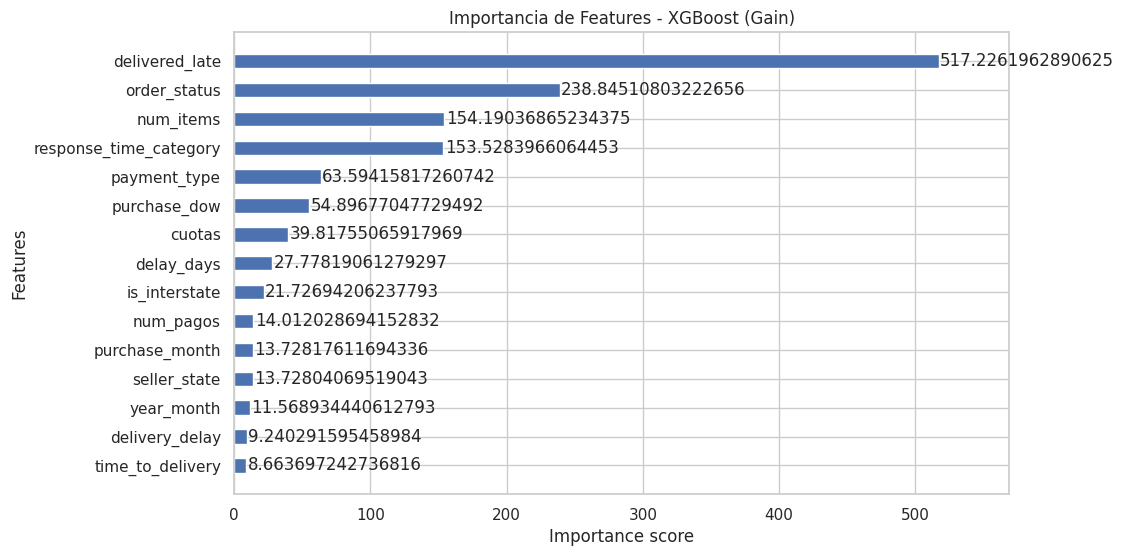

In [ ]:

# Importancia de features (gain)
importances = best_model.get_booster().get_score(importance_type='gain')

# Convertir a DataFrame y ordenar
importances_df = pd.DataFrame({
    'feature': list(importances.keys()),
    'importance': list(importances.values())
}).sort_values(by='importance', ascending=False)

# Mostrar top 15 features
print(importances_df.head(15))

# Gráfico de importancia (gain)
plt.figure(figsize=(10,6))
plot_importance(best_model, importance_type='gain', max_num_features=15, height=0.5)
plt.title('Importancia de Features - XGBoost (Gain)')
plt.show()


Número de features del modelo: 26
Número de columnas en X_explain: 34
Columnas extras en X_explain (se van a eliminar): ['customer_state_freq', 'first_category_te', 'purchase_dow_cos', 'purchase_dow_sin', 'purchase_month_cos', 'purchase_month_sin', 'seller_state_freq', 'year_month_freq']


PermutationExplainer explainer: 201it [03:14,  1.01it/s]
/tmp/ipython-input-3379749231.py:29: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_explain_aligned, max_display=20)


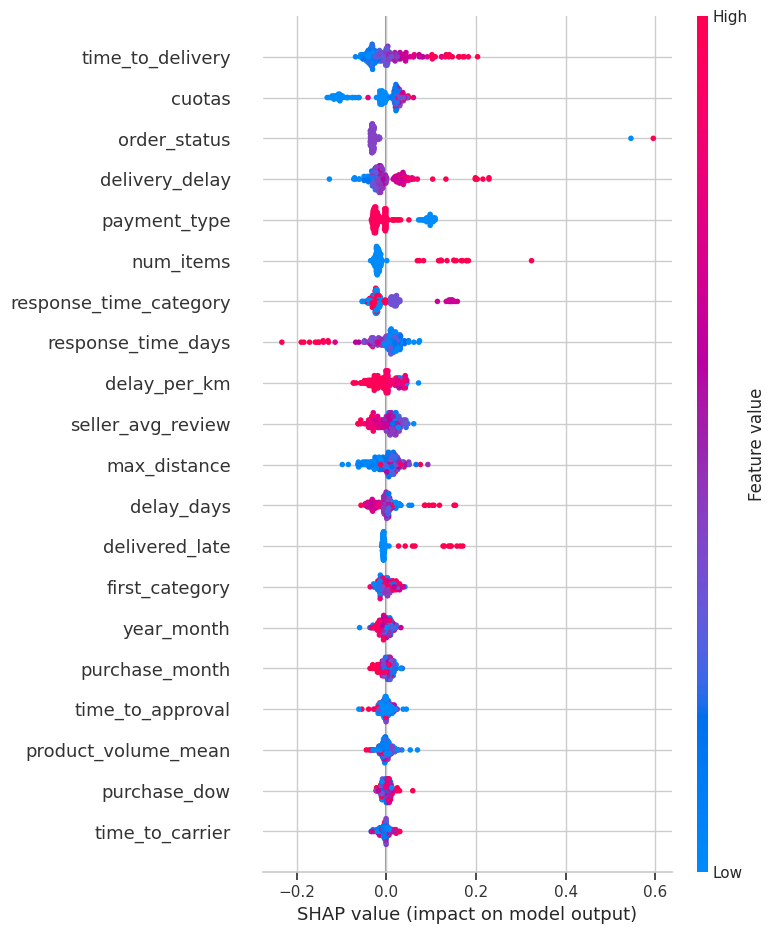

In [ ]:
# 1) recuperar las columnas que espera el modelo (seguro)
try:
    model_features = best_model.get_booster().feature_names
except Exception:
    model_features = list(getattr(best_model, "feature_names_in_", []))

# 2) mostrar comprobación rápida
print("Número de features del modelo:", len(model_features))
print("Número de columnas en X_explain:", len(X_explain.columns))
print("Columnas extras en X_explain (se van a eliminar):",
      sorted(set(X_explain.columns) - set(model_features)))

# 3) alinear X_explain y X_bg al conjunto de columnas esperado
#    -> Esto selecciona las columnas en el mismo orden que model_features.
X_explain_aligned = X_explain.loc[:, model_features].copy()

# Asegúrate de que X_bg tenga las mismas columnas:
# si tu X_train tiene esos mismos nombres:
X_bg_aligned = X_train.loc[:, model_features].sample(n=min(bg_size, len(X_train)), random_state=42)

# 4) definir la función de probabilidad (usa el pipeline o el modelo como lo tenías)
predict_proba_pos = lambda X: best_model.predict_proba(X)[:, 1]

# 5) crear explainer y calcular shap
explainer = shap.Explainer(predict_proba_pos, X_bg_aligned)
shap_values = explainer(X_explain_aligned)

# 6) plot
shap.summary_plot(shap_values, X_explain_aligned, max_display=20)



In [ ]:
# obtener columnas que el modelo espera
try:
    model_features = best_model.get_booster().feature_names
except Exception:
    model_features = list(getattr(best_model, "feature_names_in_", []))

# tomar muestra del X_test que tenga las columnas reales (no el array codificado sin nombres)
X_for_perm = X_test.loc[:, model_features].sample(n=min(2000, len(X_test)), random_state=42)
y_sub = y_test.loc[X_for_perm.index]

from sklearn.inspection import permutation_importance
r = permutation_importance(best_model, X_for_perm, y_sub,
                           n_repeats=10, random_state=42, n_jobs=-1, scoring='f1')


                       feature  importance_mean  importance_std
0                 order_status         0.118729        0.010689
1               delivered_late         0.041376        0.004053
2                       cuotas         0.024670        0.006089
3                    num_items         0.015012        0.004388
4             time_to_delivery         0.013993        0.005605
5            seller_avg_review         0.009633        0.005591
6   seller_percent_low_reviews         0.009011        0.003067
7                   delay_days         0.006964        0.007625
8          product_volume_mean         0.006187        0.005213
9                   year_month         0.005158        0.004689
10              delivery_delay         0.004821        0.010695
11                purchase_dow         0.002877        0.005329
12              customer_state         0.001963        0.003182
13                   num_pagos         0.000473        0.001643
14                 num_sellers         0

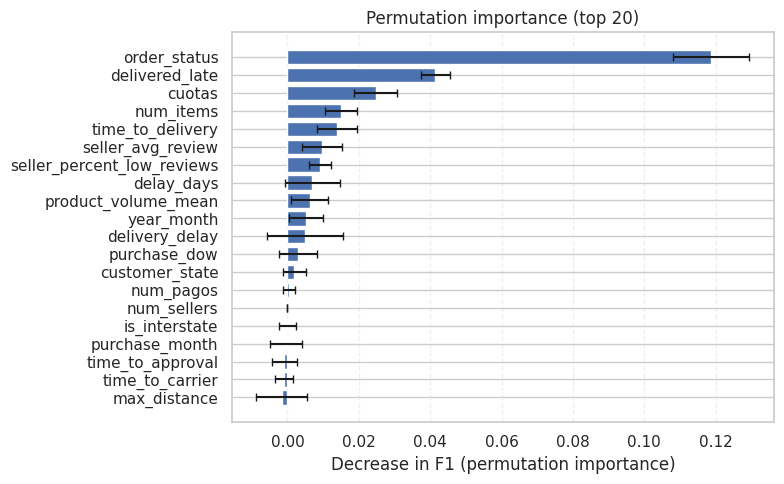

In [ ]:
import pandas as pd
import numpy as np

# Formatear resultados en DataFrame
importances = pd.DataFrame({
    'feature': X_for_perm.columns,
    'importance_mean': r.importances_mean,
    'importance_std': r.importances_std
}).sort_values('importance_mean', ascending=False).reset_index(drop=True)

# Mostrar top 30
print(importances.head(30))

# Guardar
importances.to_csv("permutation_importance_f1.csv", index=False)
print("Guardado: permutation_importance_f1.csv")

import matplotlib.pyplot as plt

topn = 20
top = importances.head(topn).iloc[::-1]  # invertir para barh

plt.figure(figsize=(8, max(4, 0.25*topn)))
plt.barh(top['feature'], top['importance_mean'], xerr=top['importance_std'], capsize=3)
plt.xlabel('Decrease in F1 (permutation importance)')
plt.title(f'Permutation importance (top {topn})')
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd

# Calcular la importancia media absoluta por feature
shap_importance = np.abs(shap_values.values).mean(axis=0)

# Crear DataFrame ordenado
shap_importance_df = pd.DataFrame({
    'feature': X_explain_aligned.columns,
    'mean_abs_shap': shap_importance
}).sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)

# Mostrar top 20
print(shap_importance_df.head(20))

# Si querés solo una lista de nombres:
shap_feature_ranking = shap_importance_df['feature'].tolist()
print("\nRanking de features (ordenadas por importancia SHAP):")
print(shap_feature_ranking[:20])  # primeras 20


                   feature  mean_abs_shap
0         time_to_delivery       0.037421
1                   cuotas       0.036676
2             order_status       0.036269
3           delivery_delay       0.033294
4             payment_type       0.032677
5                num_items       0.030401
6   response_time_category       0.028614
7       response_time_days       0.028181
8             delay_per_km       0.021893
9        seller_avg_review       0.021027
10            max_distance       0.020971
11              delay_days       0.017479
12          delivered_late       0.012771
13          first_category       0.011335
14              year_month       0.010372
15          purchase_month       0.010346
16        time_to_approval       0.008743
17     product_volume_mean       0.008631
18            purchase_dow       0.007808
19         time_to_carrier       0.007784

Ranking de features (ordenadas por importancia SHAP):
['time_to_delivery', 'cuotas', 'order_status', 'delivery_delay'

SHAP rows, feats: 200 26
Nombres SHAP (len): 26
Usando order_status de X_explain_aligned.
                  mean      std  count
order_status                          
6.0           0.595536      NaN      1
1.0           0.545688      NaN      1
3.0          -0.030871  0.00408    198


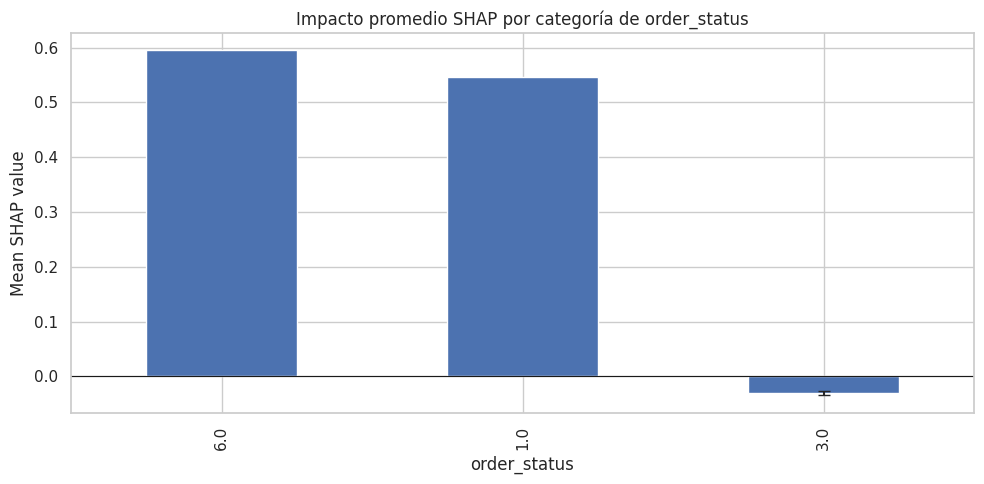

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) dimensiones SHAP
n_rows, n_feats = shap_values.values.shape
print("SHAP rows, feats:", n_rows, n_feats)

# 2) nombres detectados (los que ya tenías)
shap_feature_names = list(shap_values.feature_names)
print("Nombres SHAP (len):", len(shap_feature_names))

# 3) construir DataFrame de SHAP (sin index problemático)
shap_df = pd.DataFrame(shap_values.values, columns=shap_feature_names)

# 4) localizar una serie 'order_status' que tenga la misma longitud que shap_df
order_series = None

# Preferir X_explain_aligned si existe y tiene la misma longitud
if 'X_explain_aligned' in globals() and len(X_explain_aligned) == n_rows and 'order_status' in X_explain_aligned.columns:
    order_series = X_explain_aligned['order_status'].reset_index(drop=True)
    print("Usando order_status de X_explain_aligned.")
# Si no, usar X_explain si coincide en longitud
elif 'X_explain' in globals() and len(X_explain) == n_rows and 'order_status' in X_explain.columns:
    order_series = X_explain['order_status'].reset_index(drop=True)
    print("Usando order_status de X_explain.")
# Si ninguna tiene la misma longitud, intentar alinear por indices si existen
elif 'X_explain_aligned' in globals() and 'order_status' in X_explain_aligned.columns:
    # tomar por posición: asumimos que shap_values fue calculado sobre X_explain_aligned en el mismo orden
    order_series = X_explain_aligned['order_status'].iloc[:n_rows].reset_index(drop=True)
    print("Taking first n_rows from X_explain_aligned (posición).")
elif 'X_test' in globals() and 'order_status' in X_test.columns:
    # fallback: tomar primer n_rows de X_test (posicional)
    order_series = X_test['order_status'].iloc[:n_rows].reset_index(drop=True)
    print("Fallback: tomando first n_rows de X_test (posicional).")
else:
    raise ValueError("No encontré una columna 'order_status' adecuada en X_explain_aligned, X_explain ni X_test. Asegurate de tenerla disponible en alguna de esas variables.")

# 5) ahora combinar por posición (índices 0..n_rows-1)
tmp = pd.concat([order_series, shap_df['order_status'].reset_index(drop=True)], axis=1)
tmp.columns = ['order_status', 'shap_value']

# 6) agrupar y mostrar estadísticas
order_status_shap = tmp.groupby('order_status')['shap_value'].agg(['mean', 'std', 'count']).sort_values('mean', ascending=False)
print(order_status_shap)

# 7) gráfico (mean +/- std)
order_status_shap['mean'].plot(kind='bar', yerr=order_status_shap['std'], figsize=(10,5), capsize=4)
plt.ylabel("Mean SHAP value")
plt.title("Impacto promedio SHAP por categoría de order_status")
plt.axhline(0, color='k', linewidth=0.8)
plt.tight_layout()
plt.show()



## Revisar correlaciones entre features top

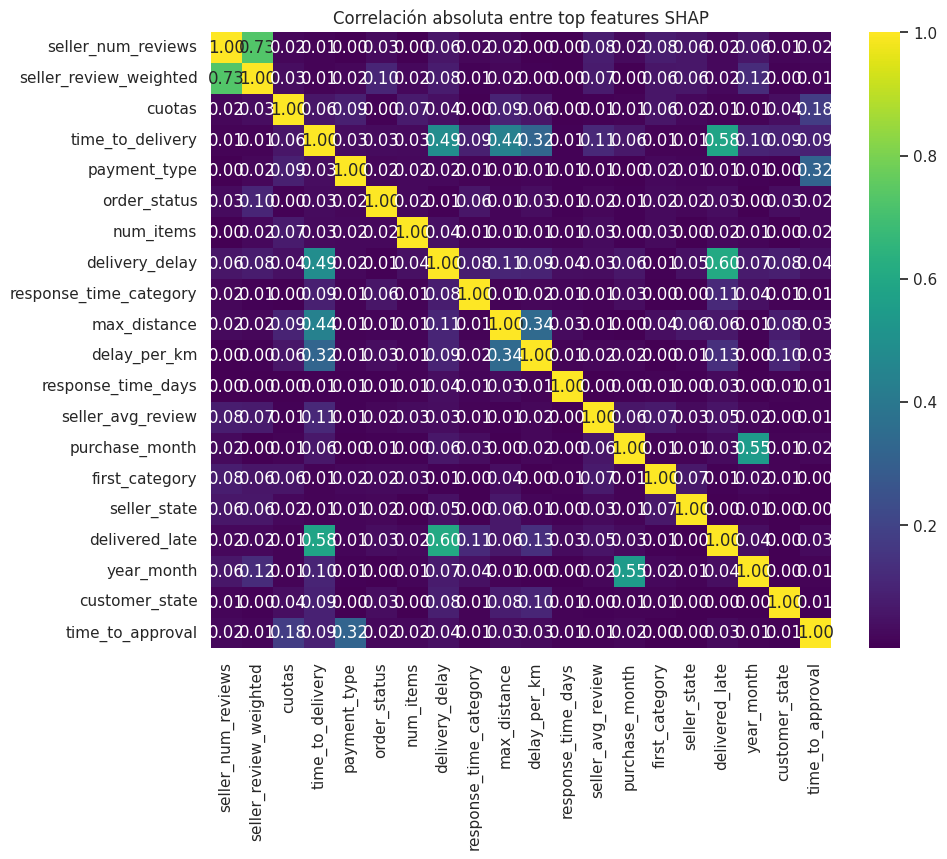

In [ ]:
perm_importance_df = pd.DataFrame({
    'feature': X_test_enc.columns,
    'importance_mean': r.importances_mean,
    'importance_std': r.importances_std
}).sort_values(by='importance_mean', ascending=False)

# 3️⃣ Merge de ambos resultados
merged = shap_importance_df.merge(perm_importance_df, on='feature', how='outer')

# 4️⃣ Tomar las 20 variables más importantes según SHAP
top_feats = merged.sort_values('mean_abs_shap', ascending=False)['feature'].head(20).tolist()

# 5️⃣ Calcular correlaciones absolutas entre esas features
corr = X_train_enc[top_feats].corr().abs()

# 6️⃣ Graficar el heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='viridis')
plt.title('Correlación absoluta entre top features SHAP')
plt.show()

## Codificacion fetures categóricas


In [ ]:
for c in cat_features:
    print(c, df_encoded[c].nunique())



payment_type 5
seller_state 23
customer_state 27
response_time_category 5
year_month 23
order_status 8
first_category 73
purchase_month 12
purchase_dow 7


payment_type (5) → One-Hot (baja cardinalidad).

response_time_category (5) → One-Hot.

order_status (8) → One-Hot (o Ordinal si querés compactar; One-Hot preferible).

purchase_month (12) → Encoding cíclico (seno/coseno) o One-Hot; cíclico mantiene relación temporal.

purchase_dow (7) → Encoding cíclico (seno/coseno) o One-Hot; cíclico recomendado.

seller_state (23) y customer_state (27) → Frequency encoding o Target encoding con CV (si hay señal y querés mayor potencia predictiva). También podés agrupar estados raros en “other”.

year_month (23) → mejor tratarlo como fecha ordinal (meses desde inicio) o target encoding; si hay tendencia temporal, usar variable numérica (número de meses) y/o features de estacionalidad.

first_category (73) → Target encoding con CV o frequency encoding; agrupar categorías raras en “other” antes de codificar.

JUSTIFICACIÓN

One-Hot: simple, interpretable y eficaz cuando pocas categorías.

Cíclico: mes/día de semana tienen orden cíclico; encodear con sin/cos evita que 12 y 1 queden lejos.

Frequency / Target encoding: para alta cardinalidad evita explotar dimensión (One-Hot crearía muchas columnas). Target encoding suele mejorar performance pero requiere CV para evitar leakage. Frequency es simple y estable.

Agrupar rare: reduce ruido y evita overfitting en categorías con poco soporte.

In [ ]:
# ============================================================
# 1️⃣ Variables categóricas y numéricas
# ============================================================
cat_features = [
    'payment_type', 'seller_state', 'customer_state',
    'response_time_category', 'year_month', 'order_status',
    'first_category', 'purchase_month', 'purchase_dow'
]

num_features = [
    'time_to_approval', 'time_to_carrier', 'time_to_delivery', 'delivery_delay',
    'num_items', 'num_sellers',
    'max_distance', 'product_volume_mean',
    'num_pagos', 'cuotas', 'response_time_days',
    'seller_avg_review', 'seller_num_reviews', 'seller_percent_low_reviews',
    'is_interstate', 'delivered_late', 'delay_days',
    'delay_per_km', 'seller_review_weighted'
]

# ============================================================
# 2️⃣ Asegurar tipo string (más seguro para transformaciones)
# ============================================================
for col in cat_features:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

# ============================================================
# 3️⃣ Agrupar categorías raras en cada variable categórica
# ============================================================
def group_rare_categories(series, min_count=100):
    """
    Reemplaza categorías con menos de 'min_count' ocurrencias por '__other__'
    """
    counts = series.value_counts()
    keep = counts[counts >= min_count].index
    return series.where(series.isin(keep), other='__other__')

# Aplicar sobre una copia del train y test
for col in cat_features:
    # Entrenamiento: agrupar las raras
    X_train[col] = group_rare_categories(X_train[col], min_count=100)

    # Test: reemplazar valores que no existen en el train
    known_cats = X_train[col].unique()
    X_test[col] = X_test[col].where(X_test[col].isin(known_cats), other='__other__')

# ============================================================
# 4️⃣ Verificación
# ============================================================
print("✅ Agrupación completada. Ejemplo de categorías resultantes:")
for col in cat_features[:5]:
    print(f"\n{col} ({len(X_train[col].unique())} categorías):")
    print(X_train[col].value_counts().head())

print("\nTrain shape:", X_train.shape, " | Test shape:", X_test.shape)


✅ Agrupación completada. Ejemplo de categorías resultantes:

payment_type (5 categorías):
payment_type
credit_card    60182
boleto         15774
voucher         2203
debit_card      1216
__other__          4
Name: count, dtype: int64

seller_state (15 categorías):
seller_state
SP    55775
MG     6317
PR     6098
RJ     3378
SC     2887
Name: count, dtype: int64

customer_state (26 categorías):
customer_state
SP    32986
RJ    10189
MG     9172
RS     4369
PR     3941
Name: count, dtype: int64

response_time_category (6 categorías):
response_time_category
1-3d     37462
<1d      19432
3-7d     18586
7-30d     3340
>30d       554
Name: count, dtype: int64

year_month (22 categorías):
year_month
2018-08    7188
2017-12    6395
2018-03    6243
2018-05    5967
2018-04    5820
Name: count, dtype: int64

Train shape: (79379, 28)  | Test shape: (19845, 28)


      first_category  first_category_te
99305           57.0           0.830265
88514           23.0           0.199793
26692           65.0           0.233727
67194           73.0           0.216931
15487           72.0           0.177290
      first_category  first_category_te
80468           66.0           0.266171
39836           65.0           0.233330
43947           73.0           0.213970
87792           59.0           0.185544
79763           50.0           0.238826
NaNs en first_category_te (train): 0
Num features for pipeline: 27
Low-card categorical (OHE): ['payment_type', 'response_time_category', 'order_status']
🔍 Columnas eliminadas por no existir en X_train: ['seller_review_weighted', 'seller_num_reviews']
✅ num_final actualizado con 25 columnas válidas.
✅ Preprocesamiento completado sin errores.
Shapes: (79379, 43) (19845, 43)
Transformed features: 43
Distribución after SMOTE: [61176 61176]


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:35:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best threshold (grid by F1): 0.360  F1=0.511

Classification report (threshold = 0.23):
              precision    recall  f1-score   support

           0      0.870     0.670     0.757     15294
           1      0.375     0.664     0.479      4551

    accuracy                          0.669     19845
   macro avg      0.622     0.667     0.618     19845
weighted avg      0.757     0.669     0.693     19845


Classification report (optimal threshold):
              precision    recall  f1-score   support

           0      0.847     0.912     0.878     15294
           1      0.601     0.445     0.511      4551

    accuracy                          0.805     19845
   macro avg      0.724     0.679     0.695     19845
weighted avg      0.790     0.805     0.794     19845

ROC AUC: 0.7392165773788409


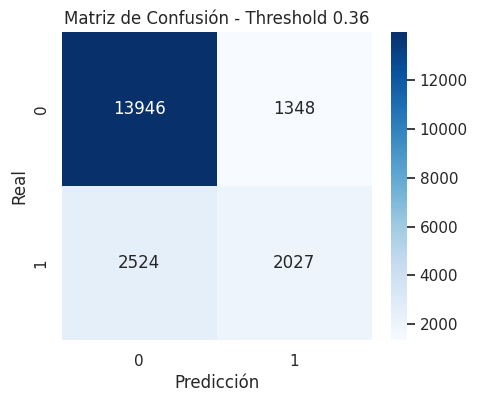

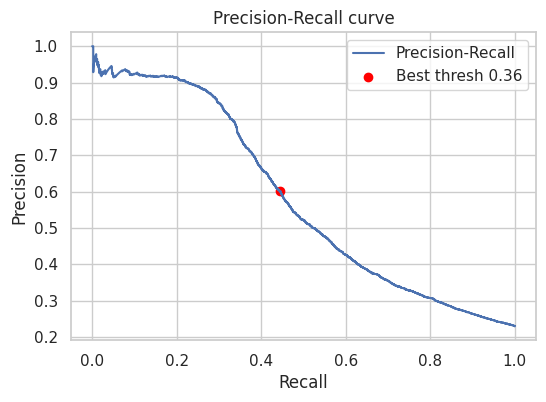

Saved preprocessor.joblib and xgb_model.joblib


In [ ]:
# =========================
# BLOQUE: target encoding / SMOTE / XGBoost (encadenado)
# =========================

# Imports (asegurate que estén)
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# -------------------------
# 1) Asegurar columnas cíclicas
# -------------------------
def ensure_cyclic(df_train, df_test, col, period):
    # si ya existen, no las recrea
    sin = f"{col}_sin"
    cos = f"{col}_cos"
    if sin not in df_train.columns:
        radians = 2 * np.pi * df_train[col].astype(int) / period
        df_train[sin] = np.sin(radians)
        radians_t = 2 * np.pi * df_test[col].astype(int) / period
        df_test[sin] = np.sin(radians_t)
    if cos not in df_train.columns:
        radians = 2 * np.pi * df_train[col].astype(int) / period
        df_train[cos] = np.cos(radians)
        radians_t = 2 * np.pi * df_test[col].astype(int) / period
        df_test[cos] = np.cos(radians_t)
    return df_train, df_test

X_train, X_test = ensure_cyclic(X_train, X_test, 'purchase_month', 12)
X_train, X_test = ensure_cyclic(X_train, X_test, 'purchase_dow', 7)

# -------------------------
# 2) Frequency encoding para seller_state, customer_state, year_month
# -------------------------
def ensure_freq_encode(train, test, col):
    freq_col = f"{col}_freq"
    if freq_col not in train.columns:
        freqs = train[col].value_counts(normalize=True)
        train[freq_col] = train[col].map(freqs)
        test[freq_col] = test[col].map(freqs).fillna(0)
    return train, test

for c in ['seller_state', 'customer_state', 'year_month']:
    X_train, X_test = ensure_freq_encode(X_train, X_test, c)

# -------------------------
# 3) Target encoding (K-Fold) para first_category si no existe ya first_category_te
# -------------------------
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np

def target_encode_kfold(train_df, test_df, col, target_series, n_splits=5, alpha=20):
    """
    Target encoding con K-Fold (sin data leakage).
    - train_df, test_df: DataFrames con la columna `col`.
    - target_series: pd.Series con el target para train_df (mismo índice que train_df).
    - Devuelve: train_df y test_df con columna '{col}_te' añadida.
    """
    # Copias para no mutar original
    train_df = train_df.copy()
    test_df = test_df.copy()

    # Asegurar target_series es Series y está alineada por índice con train_df
    if not isinstance(target_series, pd.Series):
        target_series = pd.Series(target_series, index=train_df.index)
    else:
        # si tiene distinto índice, reindexar para alinear
        target_series = target_series.reindex(train_df.index)

    # Construir df auxiliar con etiquetas originales
    tgt_name = "__target__"
    df_for = train_df[[col]].copy()
    df_for[tgt_name] = target_series

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    train_encoded = pd.Series(index=train_df.index, dtype=float)

    global_mean = float(target_series.mean())

    # Iterar con índices POSICIONALES devueltos por KFold (tr_idx, val_idx)
    for tr_idx, val_idx in kf.split(df_for):
        # obtener los labels (índices reales) de las filas de validación
        val_labels = df_for.iloc[val_idx].index

        # calcular estadísticos sobre el fold de entrenamiento (posicional)
        tr = df_for.iloc[tr_idx]
        stats = tr.groupby(col)[tgt_name].agg(['sum','count'])

        # smoothing
        smooth = (stats['sum'] + alpha * global_mean) / (stats['count'] + alpha)

        # mapear smooth a las filas de validación usando labels y asignar con loc
        mapped = df_for.loc[val_labels, col].map(smooth).fillna(global_mean)
        train_encoded.loc[val_labels] = mapped.values

    # mapping para test usando todo el train (stats_full por etiquetas)
    stats_full = df_for.groupby(col)[tgt_name].agg(['sum','count'])
    smooth_full = (stats_full['sum'] + alpha * global_mean) / (stats_full['count'] + alpha)
    test_encoded = test_df[col].map(smooth_full).fillna(global_mean)

    # Añadir columnas
    train_df[f"{col}_te"] = train_encoded
    test_df[f"{col}_te"] = test_encoded

    return train_df, test_df

# -----------------------
# -----------------------
X_train, X_test = target_encode_kfold(X_train, X_test, 'first_category', y_train, n_splits=5, alpha=20)

# Verificar
print(X_train[['first_category','first_category_te']].head())
print(X_test[['first_category','first_category_te']].head())
print("NaNs en first_category_te (train):", X_train['first_category_te'].isna().sum())


# -------------------------
# 4) Construir listas finales de features para preprocesamiento
# -------------------------
low_card_cats = ['payment_type', 'response_time_category', 'order_status']
# num_final: num_features originales + cyclic + freq encodings + first_category_te
cyclic_cols = ['purchase_month_sin','purchase_month_cos','purchase_dow_sin','purchase_dow_cos']
freq_cols = [f"{c}_freq" for c in ['seller_state','customer_state','year_month']]
num_final = list(num_features) + cyclic_cols + freq_cols + ['first_category_te']

# limpiar duplicados si los hubiera
num_final = [c for i,c in enumerate(num_final) if c not in num_final[:i]]

print("Num features for pipeline:", len(num_final))
print("Low-card categorical (OHE):", low_card_cats)

# --- Detectar y eliminar columnas inexistentes ---
expected = num_final.copy()
cols_train = set(X_train.columns)

# filtrar solo las que realmente existen en el DataFrame
num_final = [c for c in expected if c in cols_train]

# Mensaje de control
removed = list(set(expected) - set(num_final))
print("🔍 Columnas eliminadas por no existir en X_train:", removed)
print("✅ num_final actualizado con", len(num_final), "columnas válidas.")

# --- Volver a crear el preprocessor (usa num_final corregido) ---
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_final),
    ('ohe', cat_ohe, low_card_cats)
], remainder='drop', sparse_threshold=0)

# --- Reprocesar ---
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

print("✅ Preprocesamiento completado sin errores.")
print("Shapes:", X_train_proc.shape, X_test_proc.shape)


# -------------------------
# 5) Preprocessor (clip -> impute -> scale) + OHE for low-card categorical
# -------------------------
# Re-define PercentileClipper here if not in scope
from sklearn.base import BaseEstimator, TransformerMixin

class PercentileClipper(BaseEstimator, TransformerMixin):
    def __init__(self, lower_percentile=0.01, upper_percentile=0.99):
        self.lower_percentile = lower_percentile
        self.upper_percentile = upper_percentile
    def fit(self, X, y=None):
        X_arr = np.asarray(X)
        self.lower_ = np.nanpercentile(X_arr, self.lower_percentile*100, axis=0)
        self.upper_ = np.nanpercentile(X_arr, self.upper_percentile*100, axis=0)
        return self
    def transform(self, X):
        X_arr = np.asarray(X).copy()
        X_arr = np.minimum(np.maximum(X_arr, self.lower_), self.upper_)
        return X_arr

num_pipeline = Pipeline([
    ('clip', PercentileClipper(lower_percentile=0.01, upper_percentile=0.99)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_final),
    ('ohe', cat_ohe, low_card_cats)
], remainder='drop', sparse_threshold=0)

# -------------------------
# 6) Fit_transform train, transform test
# -------------------------
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

# feature names extraction helper (simple)
def get_feature_names(ct, num_cols, cat_cols):
    names = []
    # num cols: keep original names
    names += num_cols
    # cat ohe
    ohe = ct.named_transformers_['ohe']
    cat_names = []
    if hasattr(ohe, 'categories_'):
        for col, cats in zip(cat_cols, ohe.categories_):
            cat_names += [f"{col}__{c}" for c in cats]
    names += cat_names
    return names

feature_names = get_feature_names(preprocessor, num_final, low_card_cats)

print("Transformed features:", len(feature_names))

# -------------------------
# 7) Balancear con SMOTE (solo sobre train procesado)
# -------------------------
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_proc, y_train)
print("Distribución after SMOTE:", np.bincount(y_train_res))

# -------------------------
# 8) Entrenar XGBoost
# -------------------------
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    n_estimators=400,
    learning_rate=0.07,
    max_depth=5,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.2,
    random_state=42,
    use_label_encoder=False,
    n_jobs=-1
)

xgb.fit(X_train_res, y_train_res)

# -------------------------
# 9) Predicción, umbral óptimo (F1) y evaluación
# -------------------------
y_pred_proba = xgb.predict_proba(X_test_proc)[:, 1]

# calcular best threshold por F1 (evaluando grid)
thresholds_grid = np.linspace(0.01, 0.99, 99)
f1_grid = [f1_score(y_test, (y_pred_proba >= t).astype(int)) for t in thresholds_grid]
best_idx = np.argmax(f1_grid)
best_thresh = thresholds_grid[best_idx]
print(f"Best threshold (grid by F1): {best_thresh:.3f}  F1={f1_grid[best_idx]:.3f}")

manual_thresh = 0.23  # threshold manual
y_pred_opt = (y_pred_proba >= manual_thresh).astype(int)
print("\nClassification report (threshold = {:.2f}):".format(manual_thresh))
print(classification_report(y_test, y_pred_opt, digits=3))


y_pred_opt = (y_pred_proba >= best_thresh).astype(int)
print("\nClassification report (optimal threshold):")
print(classification_report(y_test, y_pred_opt, digits=3))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

# matriz de confusión
cm = confusion_matrix(y_test, y_pred_opt)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matriz de Confusión - Threshold {best_thresh:.2f}')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Precision-Recall curve with best threshold marked
precisions, recalls, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
# find closest recall,precision for best_thresh (pr_thresholds aligns differently: len = len(precisions)-1)
if len(pr_thresholds) > 0:
    idx = np.argmin(np.abs(pr_thresholds - best_thresh))
    plt.figure(figsize=(6,4))
    plt.plot(recalls[:-1], precisions[:-1], label='Precision-Recall')
    plt.scatter(recalls[:-1][idx], precisions[:-1][idx], color='red', label=f'Best thresh {best_thresh:.2f}')
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall curve'); plt.legend(); plt.show()
else:
    # fallback: plot precisions vs recalls without point
    plt.figure(figsize=(6,4))
    plt.plot(recalls, precisions, label='Precision-Recall')
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall curve'); plt.legend(); plt.show()

# -------------------------
# 10) Guardar artefactos
# -------------------------
joblib.dump(preprocessor, "preprocessor.joblib")
joblib.dump(xgb, "xgb_model.joblib")
print("Saved preprocessor.joblib and xgb_model.joblib")


       first_category  first_category_te
99305            57.0           0.830265
88514            23.0           0.199793
26692            65.0           0.233727
67194            73.0           0.216931
15487            72.0           0.177290
       first_category  first_category_te
80468            66.0           0.266171
39836            65.0           0.233330
43947            73.0           0.213970
87792            59.0           0.185544
79763            50.0           0.238826
NaNs en first_category_te (train): 0
Num features for pipeline: 25
Low-card categorical (OHE): ['payment_type', 'response_time_category', 'order_status']
Transformed features: 45
Distribución after SMOTE: [61176 61176]


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:35:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best threshold (grid by F1): 0.340  F1=0.512

Classification report (threshold = 0.23):
              precision    recall  f1-score   support

           0      0.870     0.699     0.775     15294
           1      0.390     0.649     0.487      4551

    accuracy                          0.687     19845
   macro avg      0.630     0.674     0.631     19845
weighted avg      0.760     0.687     0.709     19845


Classification report (optimal threshold):
              precision    recall  f1-score   support

           0      0.848     0.902     0.874     15294
           1      0.581     0.458     0.512      4551

    accuracy                          0.800     19845
   macro avg      0.715     0.680     0.693     19845
weighted avg      0.787     0.800     0.791     19845

ROC AUC: 0.7392793979523351


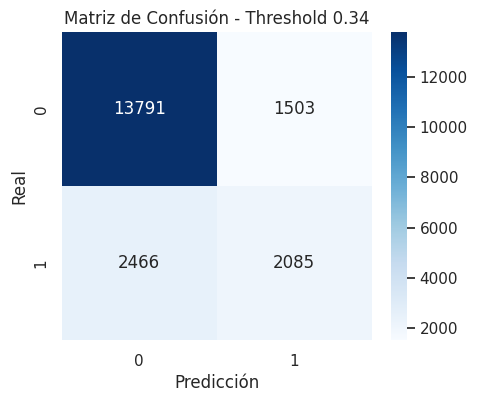

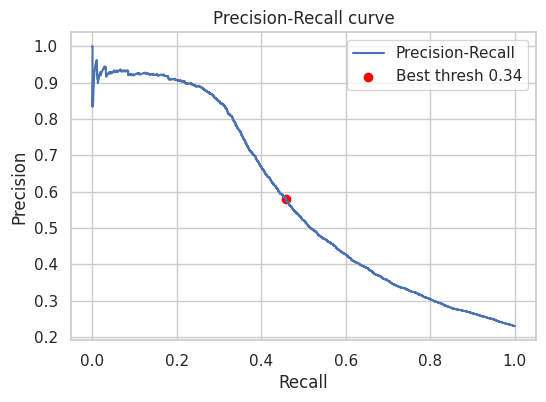

Saved preprocessor.joblib and xgb_model.joblib


In [ ]:
# =========================
# BLOQUE: target encoding / SMOTE / XGBoost (encadenado)
# =========================

# Imports (asegurate que estén)
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# -------------------------
# 1) Asegurar columnas cíclicas
# -------------------------
def ensure_cyclic(df_train, df_test, col, period):
    # si ya existen, no las recrea
    sin = f"{col}_sin"
    cos = f"{col}_cos"
    if sin not in df_train.columns:
        radians = 2 * np.pi * df_train[col].astype(int) / period
        df_train[sin] = np.sin(radians)
        radians_t = 2 * np.pi * df_test[col].astype(int) / period
        df_test[sin] = np.sin(radians_t)
    if cos not in df_train.columns:
        radians = 2 * np.pi * df_train[col].astype(int) / period
        df_train[cos] = np.cos(radians)
        radians_t = 2 * np.pi * df_test[col].astype(int) / period
        df_test[cos] = np.cos(radians_t)
    return df_train, df_test

X_train, X_test = ensure_cyclic(X_train, X_test, 'purchase_month', 12)
X_train, X_test = ensure_cyclic(X_train, X_test, 'purchase_dow', 7)

# -------------------------
# 2) Frequency encoding para seller_state, customer_state, year_month
# -------------------------
def ensure_freq_encode(train, test, col):
    freq_col = f"{col}_freq"
    if freq_col not in train.columns:
        freqs = train[col].value_counts(normalize=True)
        train[freq_col] = train[col].map(freqs)
        test[freq_col] = test[col].map(freqs).fillna(0)
    return train, test

for c in ['seller_state', 'customer_state', 'year_month']:
    X_train, X_test = ensure_freq_encode(X_train, X_test, c)

# -------------------------
# 3) Target encoding (K-Fold) para first_category si no existe ya first_category_te
# -------------------------
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np

def target_encode_kfold(train_df, test_df, col, target_series, n_splits=5, alpha=20):
    """
    Target encoding con K-Fold (sin data leakage).
    - train_df, test_df: DataFrames con la columna `col`.
    - target_series: pd.Series con el target para train_df (mismo índice que train_df).
    - Devuelve: train_df y test_df con columna '{col}_te' añadida.
    """
    # Copias para no mutar original
    train_df = train_df.copy()
    test_df = test_df.copy()

    # Asegurar target_series es Series y está alineada por índice con train_df
    if not isinstance(target_series, pd.Series):
        target_series = pd.Series(target_series, index=train_df.index)
    else:
        # si tiene distinto índice, reindexar para alinear
        target_series = target_series.reindex(train_df.index)

    # Construir df auxiliar con etiquetas originales
    tgt_name = "__target__"
    df_for = train_df[[col]].copy()
    df_for[tgt_name] = target_series

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    train_encoded = pd.Series(index=train_df.index, dtype=float)

    global_mean = float(target_series.mean())

    # Iterar con índices POSICIONALES devueltos por KFold (tr_idx, val_idx)
    for tr_idx, val_idx in kf.split(df_for):
        # obtener los labels (índices reales) de las filas de validación
        val_labels = df_for.iloc[val_idx].index

        # calcular estadísticos sobre el fold de entrenamiento (posicional)
        tr = df_for.iloc[tr_idx]
        stats = tr.groupby(col)[tgt_name].agg(['sum','count'])

        # smoothing
        smooth = (stats['sum'] + alpha * global_mean) / (stats['count'] + alpha)

        # mapear smooth a las filas de validación usando labels y asignar con loc
        mapped = df_for.loc[val_labels, col].map(smooth).fillna(global_mean)
        train_encoded.loc[val_labels] = mapped.values

    # mapping para test usando todo el train (stats_full por etiquetas)
    stats_full = df_for.groupby(col)[tgt_name].agg(['sum','count'])
    smooth_full = (stats_full['sum'] + alpha * global_mean) / (stats_full['count'] + alpha)
    test_encoded = test_df[col].map(smooth_full).fillna(global_mean)

    # Añadir columnas
    train_df[f"{col}_te"] = train_encoded
    test_df[f"{col}_te"] = test_encoded

    return train_df, test_df

# -----------------------
# -----------------------
X_train, X_test = target_encode_kfold(X_train, X_test, 'first_category', y_train, n_splits=5, alpha=20)

# Verificar
print(X_train[['first_category','first_category_te']].head())
print(X_test[['first_category','first_category_te']].head())
print("NaNs en first_category_te (train):", X_train['first_category_te'].isna().sum())


# -------------------------
# 4) Construir listas finales de features para preprocesamiento
# -------------------------
low_card_cats = ['payment_type', 'response_time_category', 'order_status']
# num_final: num_features originales + cyclic + freq encodings + first_category_te
cyclic_cols = ['purchase_month_sin','purchase_month_cos','purchase_dow_sin','purchase_dow_cos']
freq_cols = [f"{c}_freq" for c in ['seller_state','customer_state','year_month']]
num_final = list(num_features) + cyclic_cols + freq_cols + ['first_category_te']

# limpiar duplicados si los hubiera
num_final = [c for i,c in enumerate(num_final) if c not in num_final[:i]]

print("Num features for pipeline:", len(num_final))
print("Low-card categorical (OHE):", low_card_cats)

# -------------------------
# 5) Preprocessor (clip -> impute -> scale) + OHE for low-card categorical
# -------------------------
# Re-define PercentileClipper here if not in scope
from sklearn.base import BaseEstimator, TransformerMixin

class PercentileClipper(BaseEstimator, TransformerMixin):
    def __init__(self, lower_percentile=0.01, upper_percentile=0.99):
        self.lower_percentile = lower_percentile
        self.upper_percentile = upper_percentile
    def fit(self, X, y=None):
        X_arr = np.asarray(X)
        self.lower_ = np.nanpercentile(X_arr, self.lower_percentile*100, axis=0)
        self.upper_ = np.nanpercentile(X_arr, self.upper_percentile*100, axis=0)
        return self
    def transform(self, X):
        X_arr = np.asarray(X).copy()
        X_arr = np.minimum(np.maximum(X_arr, self.lower_), self.upper_)
        return X_arr

num_pipeline = Pipeline([
    ('clip', PercentileClipper(lower_percentile=0.01, upper_percentile=0.99)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_final),
    ('ohe', cat_ohe, low_card_cats)
], remainder='drop', sparse_threshold=0)

# -------------------------
# 6) Fit_transform train, transform test
# -------------------------
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

# feature names extraction helper (simple)
def get_feature_names(ct, num_cols, cat_cols):
    names = []
    # num cols: keep original names
    names += num_cols
    # cat ohe
    ohe = ct.named_transformers_['ohe']
    cat_names = []
    if hasattr(ohe, 'categories_'):
        for col, cats in zip(cat_cols, ohe.categories_):
            cat_names += [f"{col}__{c}" for c in cats]
    names += cat_names
    return names

feature_names = get_feature_names(preprocessor, num_final, low_card_cats)

print("Transformed features:", len(feature_names))

# -------------------------
# 7) Balancear con SMOTE (solo sobre train procesado)
# -------------------------
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_proc, y_train)
print("Distribución after SMOTE:", np.bincount(y_train_res))

# -------------------------
# 8) Entrenar XGBoost
# -------------------------
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    n_estimators=400,
    learning_rate=0.07,
    max_depth=5,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.2,
    random_state=42,
    use_label_encoder=False,
    n_jobs=-1
)

xgb.fit(X_train_res, y_train_res)

# -------------------------
# 9) Predicción, umbral óptimo (F1) y evaluación
# -------------------------
y_pred_proba = xgb.predict_proba(X_test_proc)[:, 1]

# calcular best threshold por F1 (evaluando grid)
thresholds_grid = np.linspace(0.01, 0.99, 99)
f1_grid = [f1_score(y_test, (y_pred_proba >= t).astype(int)) for t in thresholds_grid]
best_idx = np.argmax(f1_grid)
best_thresh = thresholds_grid[best_idx]
print(f"Best threshold (grid by F1): {best_thresh:.3f}  F1={f1_grid[best_idx]:.3f}")

manual_thresh = 0.23  # threshold manual
y_pred_opt = (y_pred_proba >= manual_thresh).astype(int)
print("\nClassification report (threshold = {:.2f}):".format(manual_thresh))
print(classification_report(y_test, y_pred_opt, digits=3))


y_pred_opt = (y_pred_proba >= best_thresh).astype(int)
print("\nClassification report (optimal threshold):")
print(classification_report(y_test, y_pred_opt, digits=3))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

# matriz de confusión
cm = confusion_matrix(y_test, y_pred_opt)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matriz de Confusión - Threshold {best_thresh:.2f}')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Precision-Recall curve with best threshold marked
precisions, recalls, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
# find closest recall,precision for best_thresh (pr_thresholds aligns differently: len = len(precisions)-1)
if len(pr_thresholds) > 0:
    idx = np.argmin(np.abs(pr_thresholds - best_thresh))
    plt.figure(figsize=(6,4))
    plt.plot(recalls[:-1], precisions[:-1], label='Precision-Recall')
    plt.scatter(recalls[:-1][idx], precisions[:-1][idx], color='red', label=f'Best thresh {best_thresh:.2f}')
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall curve'); plt.legend(); plt.show()
else:
    # fallback: plot precisions vs recalls without point
    plt.figure(figsize=(6,4))
    plt.plot(recalls, precisions, label='Precision-Recall')
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall curve'); plt.legend(); plt.show()

# -------------------------
# 10) Guardar artefactos
# -------------------------
joblib.dump(preprocessor, "preprocessor.joblib")
joblib.dump(xgb, "xgb_model.joblib")
print("Saved preprocessor.joblib and xgb_model.joblib")


                   feature  importance
13          delivered_late  517.226196
21            order_status  238.845108
4                num_items  154.190369
19  response_time_category  153.528397
16            payment_type   63.594158
24            purchase_dow   54.896770
8                   cuotas   39.817551
14              delay_days   27.778191
12           is_interstate   21.726942
7                num_pagos   14.012029
23          purchase_month   13.728176
17            seller_state   13.728041
20              year_month   11.568934
3           delivery_delay    9.240292
2         time_to_delivery    8.663697


<Figure size 1000x600 with 0 Axes>

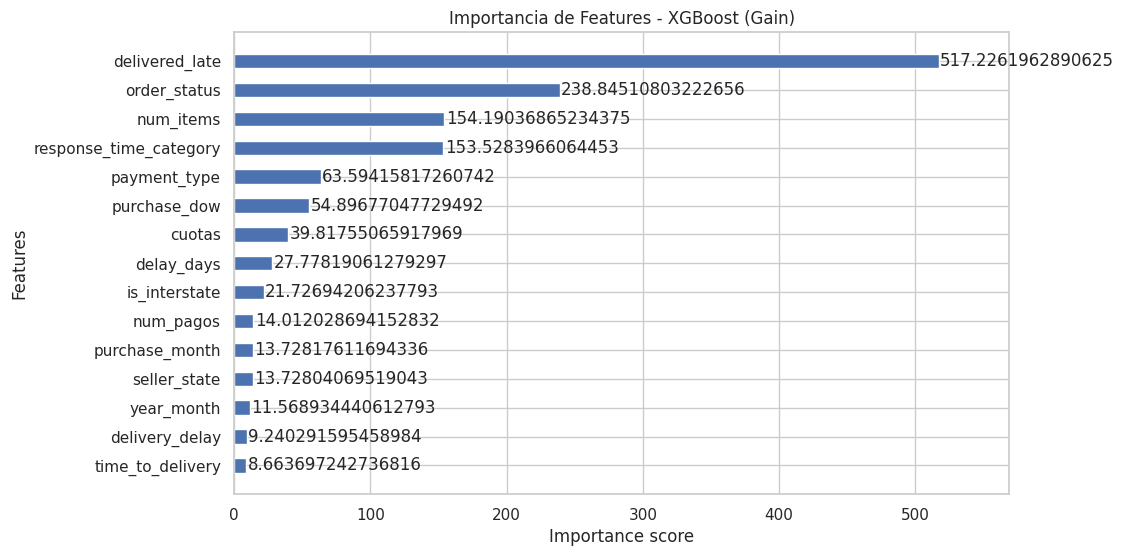

In [ ]:
from xgboost import plot_importance

# Importancia por gain
importances = best_model.get_booster().get_score(importance_type='gain')

# Convertir a DataFrame
importance_df = pd.DataFrame({
    'feature': list(importances.keys()),
    'importance': list(importances.values())
}).sort_values(by='importance', ascending=False)

# Top 15
print(importance_df.head(15))

# Gráfico (usa directamente el booster)
plt.figure(figsize=(10,6))
plot_importance(best_model, importance_type='gain', max_num_features=15, height=0.5)
plt.title('Importancia de Features - XGBoost (Gain)')
plt.show()


In [ ]:
# Verificar tamaños
print("len(feature_names):", len(feature_names))
print("len(r.importances_mean):", len(r.importances_mean))

# Si no coinciden, recortamos feature_names al tamaño de r.importances_mean
feature_names_trimmed = feature_names[:len(r.importances_mean)]

perm_importance_df = pd.DataFrame({
    'feature': feature_names_trimmed,
    'importance_mean': r.importances_mean,
    'importance_std': r.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(perm_importance_df.head(15))



len(feature_names): 45


NameError: name 'r' is not defined

In [ ]:
shap.summary_plot(shap_values, X_explain, max_display=20)


/tmp/ipython-input-314538910.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_explain, max_display=20)


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

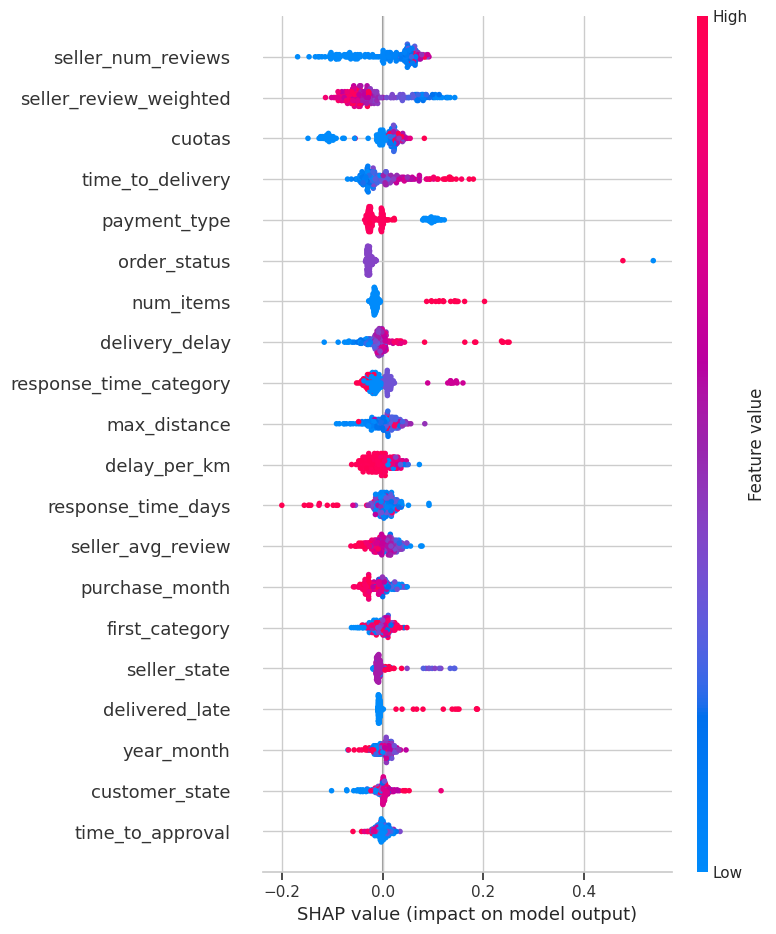

In [ ]:
shap.summary_plot(shap_values, X_explain, max_display=20)


## Depuración del modelo

Los diferentes enfoques de interpretación del modelo —incluyendo la importancia de variables (Gain y Permutation Importance) y los valores SHAP, tanto a nivel global como individual— fueron analizados de manera conjunta con el objetivo de depurar y optimizar el conjunto de predictores. Este análisis integrado permitió eliminar aquellas variables que no aportaban información relevante en ninguno de los métodos y, al mismo tiempo, revisar con mayor detalle las que mostraron una contribución consistente, favoreciendo un modelo final más simple, robusto y explicable.


In [ ]:
# Ejemplos de categorías después de agrupar raras
for col in ['payment_type', 'seller_state', 'customer_state', 'first_category']:
    print(f"\n{col} - categorías en train:")
    print(X_train[col].value_counts().head(10))


payment_type - categorías en train:
payment_type
credit_card    60182
boleto         15774
voucher         2203
debit_card      1216
__other__          4
Name: count, dtype: int64

seller_state - categorías en train:
seller_state
SP     55775
MG      6317
PR      6098
RJ      3378
SC      2887
RS      1590
DF       673
nan      617
BA       462
GO       369
Name: count, dtype: int64

customer_state - categorías en train:
customer_state
SP    32986
RJ    10189
MG     9172
RS     4369
PR     3941
SC     2931
BA     2629
DF     1729
GO     1634
ES     1615
Name: count, dtype: int64

first_category - categorías en train:
first_category
ropa_de_cama_mesa_y_banho    7406
belleza_y_salud              7024
deportes_y_ocio              6110
informatica_accesorios       5355
muebles_y_decoracion         5136
utilidades_domesticas        4689
relojes_y_regalos            4504
telefonia                    3283
automotriz                   3098
juguetes                     3057
Name: count, dtype:

In [ ]:
# Tomar la misma muestra que usaste para SHAP, pero en datos originales (sin codificar)
expl_sample_size = 200
X_explain_raw = X_test.sample(n=min(expl_sample_size, len(X_test)), random_state=42)

# Si X_explain lo tenías codificado, asegurate de que coincide en filas
X_explain = preprocessor.transform(X_explain_raw)  # si querés usarlo para SHAP



In [ ]:
# Tomar la misma muestra SHAP, pero en datos originales (sin codificar)
expl_sample_size = 200
X_explain_raw = X_test.sample(n=min(expl_sample_size, len(X_test)), random_state=42)

# Asegur de que coincide en filas
X_explain = preprocessor.transform(X_explain_raw)


In [ ]:
# Muestra de test original (sin codificar)
expl_sample_size = 200
X_explain_raw = X_test.sample(n=min(expl_sample_size, len(X_test)), random_state=42)

# Transformar con preprocessor para SHAP
X_explain_proc = preprocessor.transform(X_explain_raw)

# Construir explainer y calcular SHAP values (ya lo hiciste antes)
predict_proba_pos = lambda X: xgb.predict_proba(X)[:, 1]
explainer = shap.Explainer(predict_proba_pos, X_train_proc[:500])  # background sample
shap_values = explainer(X_explain_proc)

# Obtener las columnas OHE de payment_type
ohe = preprocessor.named_transformers_['ohe']
payment_cols_idx = [i for i, c in enumerate(feature_names) if c.startswith('payment_type__')]

# Crear DataFrame con categorías originales y SHAP promedio
shap_payment = pd.DataFrame({
    'payment_type': [c.split('__')[1] for c in np.array(feature_names)[payment_cols_idx]],
    'shap_value': [shap_values.values[:, i].mean() for i in payment_cols_idx]
})

print(shap_payment.sort_values('shap_value', ascending=False))



PermutationExplainer explainer: 201it [01:12,  2.60it/s]

  payment_type  shap_value
4      voucher    0.000114
0                 0.000000
3   debit_card   -0.000117
2  credit_card   -0.000260
1       boleto   -0.000366


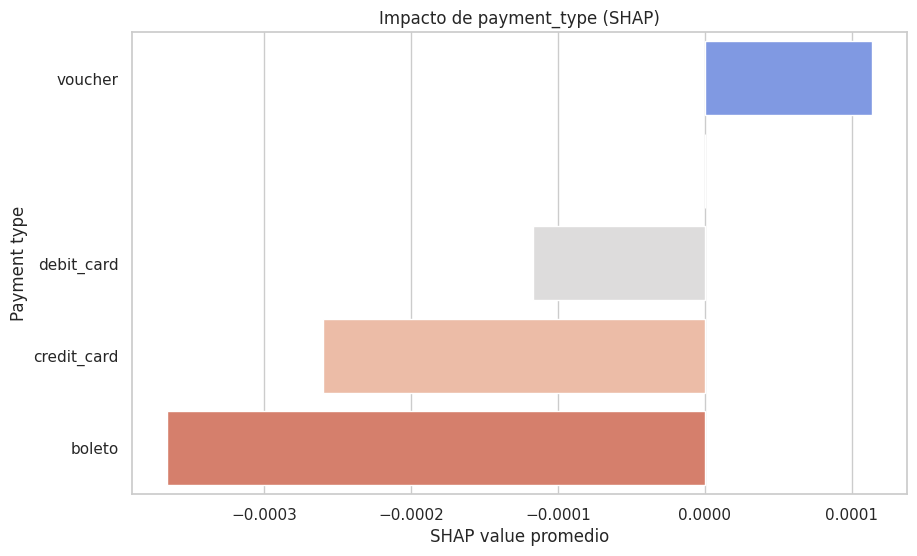

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(data=shap_payment.sort_values('shap_value', ascending=False),
            x='shap_value', y='payment_type', palette='coolwarm')
plt.title("Impacto de payment_type (SHAP)")
plt.xlabel("SHAP value promedio")
plt.ylabel("Payment type")
plt.show()


## Explicación resumen - SHAP XGBoost (0 = Buenas, 1 = Malas)

- **Eje vertical:** Features ordenadas de mayor a menor importancia global.  
- **Eje horizontal:** Contribución al modelo:
  - Valores positivos → empujan hacia **mala review (1)**  
  - Valores negativos → empujan hacia **buena review (0)**  
- **Color de puntos:** representa el valor de la feature (rojo = alto, azul = bajo).

**Interpretación de features clave:**

- `order_status` y `response_time_category`: valores altos aumentan probabilidad de mala review.  
- `num_items`: menor cantidad de ítems tiende a asociarse a mala review.  
- `payment_type`: ciertos métodos de pago muestran tendencia a mala review.

**Conclusión:**  
El gráfico SHAP ayuda a:
1. Identificar features más importantes.
2. Entender cómo influyen en la predicción.  
3. Detectar variables que no deberían usarse en producción.


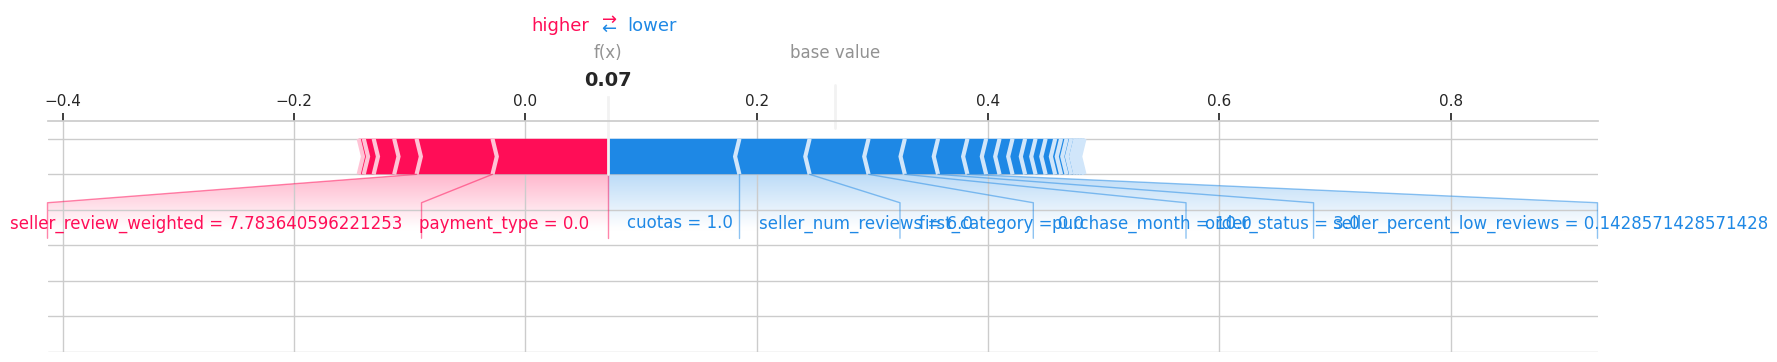

In [ ]:


# Mostrar force plot para la primera observación (API nueva)
import shap
shap.plots.force(shap_values[0], matplotlib=True)   # matplotlib=True si preferís salida en matplotlib


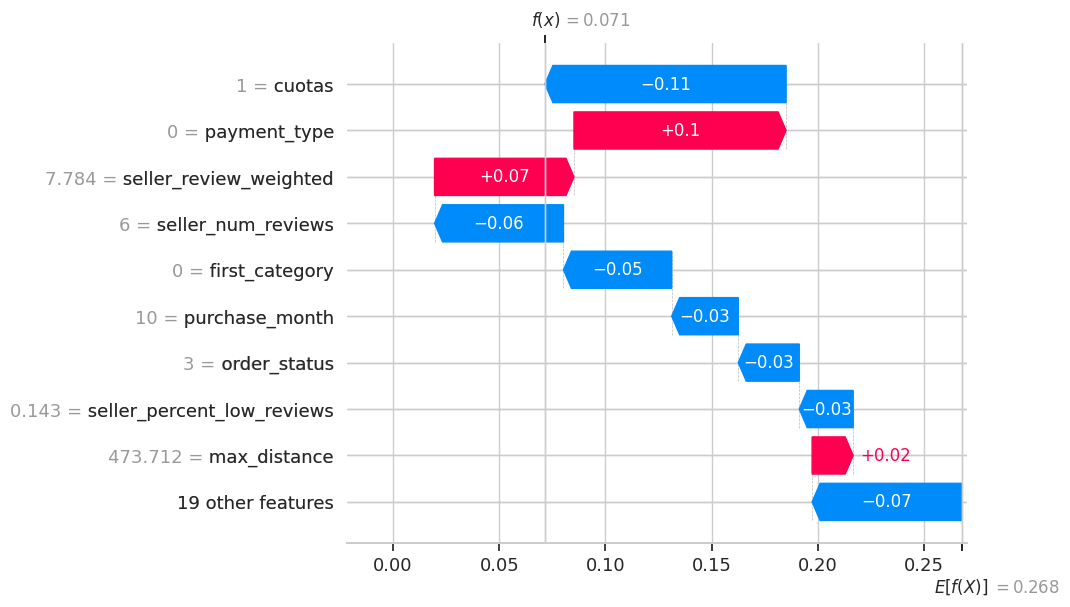

In [ ]:
shap.plots.waterfall(shap_values[0])


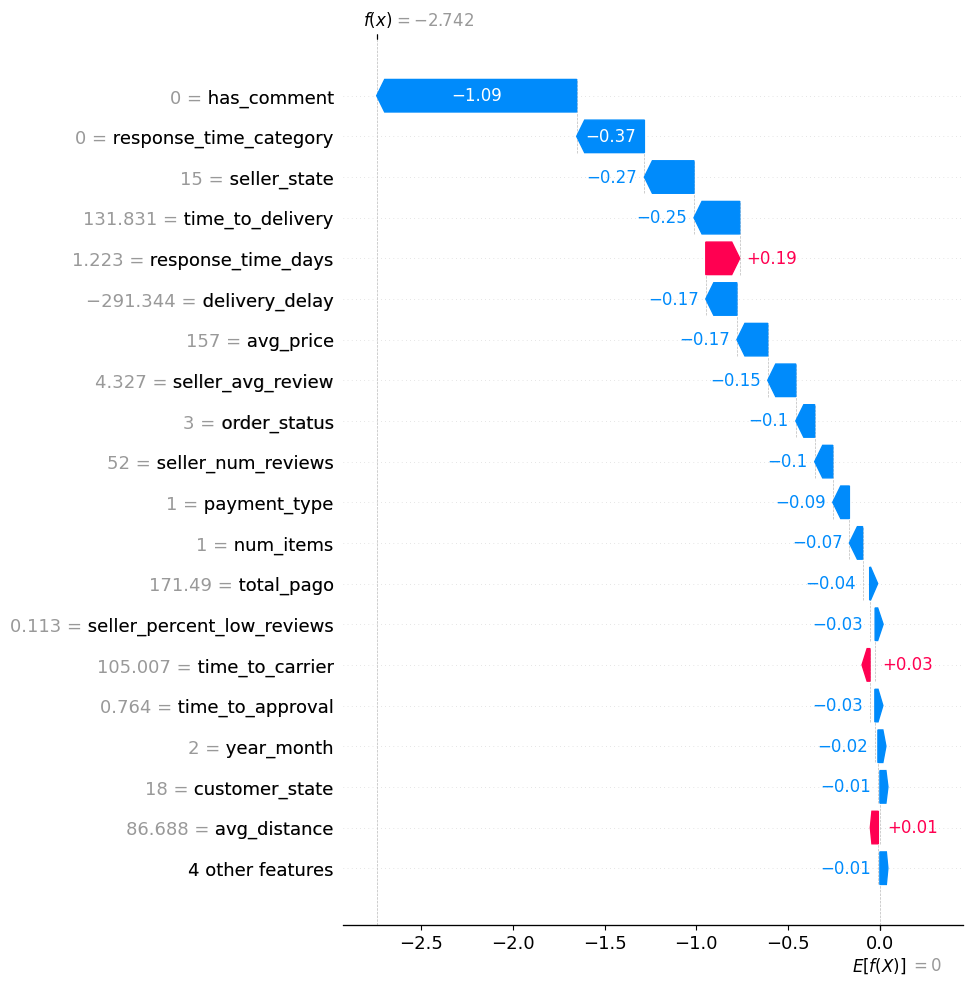

In [ ]:
idx = 0  # fila que queremos explicar

# Usando waterfall_plot (versión moderna, más legible)
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[idx, :],
        base_values=explainer.expected_value[0],  # <-- pasa un escalar
        data=X_test_enc.iloc[idx, :],
        feature_names=X_test_enc.columns
    ),
    max_display=20  # cantidad de features a mostrar
)



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# =========================
# 1. Predicciones
# =========================
y_pred_proba = best_model.predict_proba(X_test_selected)[:, 1]

manual_thresh = 0.25  # 👈 podés cambiar este valor
y_pred_manual = (y_pred_proba >= manual_thresh).astype(int)

# =========================
# 2. Métricas
# =========================
print(f"\n📊 Classification Report (Threshold = {manual_thresh}):")
print(classification_report(y_test, y_pred_manual, digits=3))
print("🔥 ROC AUC:", roc_auc_score(y_test, y_pred_proba))

# =========================
# 3. Matriz de confusión
# =========================
cm = confusion_matrix(y_test, y_pred_manual)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Mala','Buena'], yticklabels=['Mala','Buena'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title(f'Matriz de Confusión - Threshold {manual_thresh}')
plt.show()

# =========================
# 4. Precision-Recall Curve
# =========================
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(7,5))
plt.plot(recalls, precisions, label='Precision-Recall curve')

# Línea del threshold manual
if manual_thresh <= thresholds[-1]:
    idx = np.searchsorted(thresholds, manual_thresh)
    plt.axvline(x=recalls[idx], color='green', linestyle='--', label=f'Threshold manual: {manual_thresh}')
else:
    print("⚠️ El threshold manual está fuera del rango de thresholds calculados.")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall - Threshold Manual')
plt.legend()
plt.show()


In [ ]:
## Random Forest Optimizada

# Probar también eval_metric='aucpr' en lugar de accuracy o f1 — el AUC-PR mide mejor el rendimiento en desbalance.




# Random Forest

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
from imblearn.pipeline import Pipeline


In [ ]:

# --- Cargar datos ---
file_id = '1k0QbHgIGbYPcUhvGo3JiezfYhr4QDixo'
csv_url = f'https://drive.google.com/uc?export=download&id={file_id}'
df = pd.read_csv(csv_url)

# --- Selección de columnas numéricas ---
num_cols = df.select_dtypes(include=np.number).columns.tolist()
X = df[num_cols].drop(columns=['review_score'], errors='ignore')
y = (df['review_score'] == 5).astype(int)  # modelo binario: 5 vs resto

# --- Train/Test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Pipeline con SMOTE y Random Forest ---
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # imputación
    ('scaler', StandardScaler()),                # escalado
    ('smote', SMOTE(random_state=42)),          # balanceo solo sobre train
    ('rf', RandomForestClassifier(
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ))
])

# --- GridSearch de hiperparámetros simplificado ---
param_grid = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [None, 10],
    'rf__max_features': ['sqrt', 'log2']
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# --- Entrenar modelo ---
grid.fit(X_train, y_train)

# --- Resultados ---
print("Mejores parámetros:", grid.best_params_)
print("Mejor AUC CV:", grid.best_score_)

# --- Predicciones y métricas en test ---
best_model = grid.best_estimator_
y_prob = best_model.predict_proba(X_test)[:,1]
threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

print("AUC-ROC:", roc_auc_score(y_test, y_prob))
print("AP (Precision-Recall):", average_precision_score(y_test, y_prob))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))




Fitting 3 folds for each of 8 candidates, totalling 24 fits
Mejores parámetros: {'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__n_estimators': 100}
Mejor AUC CV: 0.6199106669900846
AUC-ROC: 0.6227724843058589
AP (Precision-Recall): 0.6591130043477286

Classification report:
               precision    recall  f1-score   support

           0       0.54      0.48      0.51      8533
           1       0.64      0.70      0.67     11466

    accuracy                           0.61     19999
   macro avg       0.59      0.59      0.59     19999
weighted avg       0.60      0.61      0.60     19999


Confusion matrix:
 [[4057 4476]
 [3409 8057]]


In [ ]:
import pandas as pd


file_id = '1k0QbHgIGbYPcUhvGo3JiezfYhr4QDixo'

# Enlace de descarga directa
csv_url = f'https://drive.google.com/uc?export=download&id={file_id}'

# Leer el CSV
df = pd.read_csv(csv_url)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99992 entries, 0 to 99991
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       99992 non-null  object 
 1   customer_id                    99992 non-null  object 
 2   order_status                   99992 non-null  object 
 3   order_purchase_timestamp       99992 non-null  object 
 4   order_approved_at              99831 non-null  object 
 5   order_delivered_carrier_date   98199 non-null  object 
 6   order_delivered_customer_date  97005 non-null  object 
 7   order_estimated_delivery_date  99992 non-null  object 
 8   num_items                      99214 non-null  float64
 9   num_sellers                    99214 non-null  float64
 10  avg_price                      99214 non-null  float64
 11  total_freight                  99214 non-null  float64
 12  first_shipping_limit           99214 non-null 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Cargar datos
file_id = '1k0QbHgIGbYPcUhvGo3JiezfYhr4QDixo'
csv_url = f'https://drive.google.com/uc?export=download&id={file_id}'
df = pd.read_csv(csv_url)

# Seleccionar columnas numéricas (excluyendo la variable target)
X = df.select_dtypes(include=np.number).drop(columns=['review_score'], errors='ignore')

# Variable binaria: 5 vs resto
y = (df['review_score'] == 5).astype(int)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Imputar valores faltantes
imputer = SimpleImputer(strategy='mean')
X_train_proc = imputer.fit_transform(X_train)
X_test_proc = imputer.transform(X_test)

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_proc, y_train)

# Predicciones y probabilidades
y_prob = rf.predict_proba(X_test_proc)[:,1]
y_pred = rf.predict(X_test_proc)

# Métricas
print("AUC-ROC:", roc_auc_score(y_test, y_prob))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


AUC-ROC: 0.5994967026466582

Classification report:
               precision    recall  f1-score   support

           0       0.55      0.36      0.44      8533
           1       0.62      0.78      0.69     11466

    accuracy                           0.60     19999
   macro avg       0.58      0.57      0.56     19999
weighted avg       0.59      0.60      0.58     19999

Confusion matrix:
 [[3099 5434]
 [2579 8887]]


In [ ]:

# --- Seleccionar solo columnas numéricas ---
X = df.select_dtypes(include=np.number).drop(columns=['review_score'], errors='ignore')
y = (df['review_score'] == 5).astype(int)  # 1 si review_score==5, 0 si <5

# --- Separar train/test ---
X_train, X_test, y_train_bin, y_test_bin = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Imputar valores faltantes ---
imputer = SimpleImputer(strategy='mean')
X_train_proc = imputer.fit_transform(X_train)
X_test_proc = imputer.transform(X_test)

# --- Entrenar Random Forest ---
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # opcional para desbalance
)
rf.fit(X_train_proc, y_train_bin)

# --- Predecir probabilidades ---
y_prob = rf.predict_proba(X_test_proc)[:,1]

# --- Evaluar con threshold por defecto 0.5 ---
threshold = 0.68  # probá entre 0.5 y 0.7
y_pred_thresh = (y_prob >= threshold).astype(int)

print("AUC-ROC:", roc_auc_score(y_test_bin, y_prob))
print("\nClassification report:\n", classification_report(y_test_bin, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test_bin, y_pred))



AUC-ROC: 0.5982621434899147

Classification report:
               precision    recall  f1-score   support

           0       0.55      0.34      0.42      8533
           1       0.62      0.79      0.69     11466

    accuracy                           0.60     19999
   macro avg       0.58      0.57      0.56     19999
weighted avg       0.59      0.60      0.58     19999


Confusion matrix:
 [[2936 5597]
 [2408 9058]]


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

param_grid = {
    'n_estimators': [200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2', None]
}

grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train_proc, y_train_bin)

print("Best params:", grid_search.best_params_)
print("Best AUC:", grid_search.best_score_)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:

# --- Cargar datos ---
file_id = '1k0QbHgIGbYPcUhvGo3JiezfYhr4QDixo'
csv_url = f'https://drive.google.com/uc?export=download&id={file_id}'
df = pd.read_csv(csv_url)

# --- Columnas numéricas ---
num_cols = df.select_dtypes(include=np.number).columns.tolist()
X = df[num_cols].copy()
y = (df['review_score'] == 5).astype(int)  # modelo binario 5 vs resto

# --- Train/Test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- Imputación ---
imputer = SimpleImputer(strategy='mean')
X_train_proc = imputer.fit_transform(X_train)
X_test_proc = imputer.transform(X_test)

# --- Escalado ---
scaler = StandardScaler()
X_train_proc = scaler.fit_transform(X_train_proc)
X_test_proc = scaler.transform(X_test_proc)

# --- SMOTE para balancear ---
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train_proc, y_train)

print("Nuevo shape balanceado:", X_train_bal.shape)
print("Distribución clases:", np.unique(y_train_bal, return_counts=True))

# --- Random Forest con GridSearch básico ---
rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

grid = GridSearchCV(rf, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
grid.fit(X_train_bal, y_train_bal)

print("Mejores parámetros RF:", grid.best_params_)
print("Mejor AUC en CV:", grid.best_score_)

# --- Evaluación en test ---
best_rf = grid.best_estimator_
y_prob = best_rf.predict_proba(X_test_proc)[:,1]

# Ajuste de threshold (ej: 0.5 o probar otro)
threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

print("AUC-ROC:", roc_auc_score(y_test, y_prob))
print("AP (Precision-Recall):", average_precision_score(y_test, y_prob))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))


Nuevo shape balanceado: (91724, 13)
Distribución clases: (array([0, 1]), array([45862, 45862]))
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Mejores parámetros RF: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mejor AUC en CV: 1.0
AUC-ROC: 1.0
AP (Precision-Recall): 1.0

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8533
           1       1.00      1.00      1.00     11466

    accuracy                           1.00     19999
   macro avg       1.00      1.00      1.00     19999
weighted avg       1.00      1.00      1.00     19999


Confusion matrix:
 [[ 8533     0]
 [    0 11466]]



Top 10 features más importantes:
               feature  importance
11  response_time_days    0.214978
4         avg_distance    0.195293
5           total_pago    0.168052
3        total_freight    0.156849
2            avg_price    0.153462
7               cuotas    0.055671
8          has_comment    0.013588
10     has_any_comment    0.012181
0            num_items    0.011022
6            num_pagos    0.007908


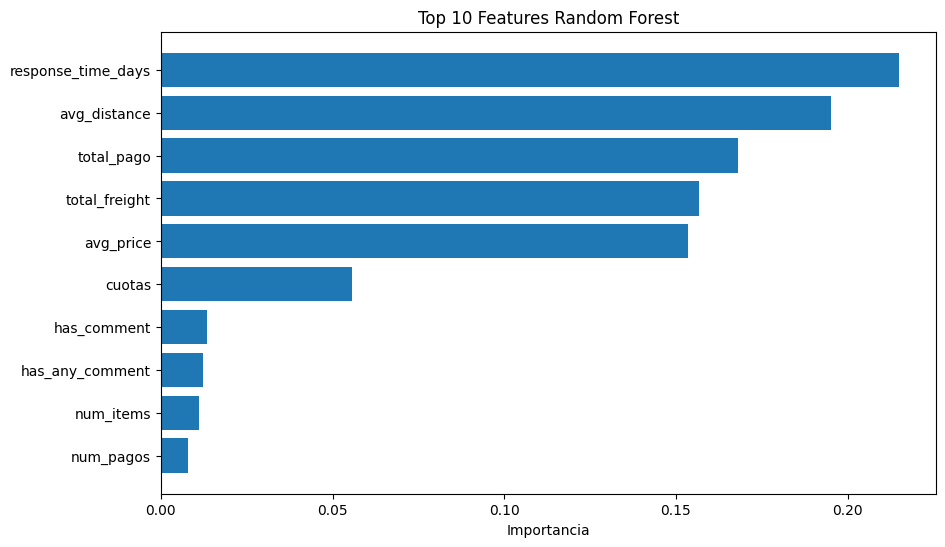

In [ ]:
# Importancia de features
importances = rf.feature_importances_
feature_names = X.columns

feat_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nTop 10 features más importantes:")
print(feat_importances.head(10))

# Opcional: visualizar
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(feat_importances['feature'][:10][::-1], feat_importances['importance'][:10][::-1])
plt.xlabel('Importancia')
plt.title('Top 10 Features Random Forest')
plt.show()


In [ ]:


# --- Cargar datos ---
file_id = '1k0QbHgIGbYPcUhvGo3JiezfYhr4QDixo'
csv_url = f'https://drive.google.com/uc?export=download&id={file_id}'
df = pd.read_csv(csv_url)

# --- Variables numéricas sin la target ---
num_cols = df.select_dtypes(include=np.number).columns.tolist()
num_cols.remove('review_score')  # eliminamos la variable objetivo
X = df[num_cols].copy()
y = (df['review_score'] == 5).astype(int)

# --- Train/Test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Imputación ---
imputer = SimpleImputer(strategy='mean')
X_train_proc = imputer.fit_transform(X_train)
X_test_proc = imputer.transform(X_test)

# --- Escalado ---
scaler = StandardScaler()
X_train_proc = scaler.fit_transform(X_train_proc)
X_test_proc = scaler.transform(X_test_proc)

# --- SMOTE ---
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train_proc, y_train)

# --- Random Forest completo ---
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_bal, y_train_bal)

# --- Importancia de features ---
importances = rf.feature_importances_
feat_names = X.columns
feat_imp_df = pd.DataFrame({'feature': feat_names, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)

print("Top 10 features más importantes:")
print(feat_imp_df.head(10))

# --- Entrenar solo con top N features ---
top_features = feat_imp_df['feature'].head(10).tolist()
X_train_top = pd.DataFrame(X_train_proc, columns=X.columns)[top_features].values
X_test_top = pd.DataFrame(X_test_proc, columns=X.columns)[top_features].values

rf_top = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf_top.fit(X_train_top, y_train)  # opcional: usar SMOTE de nuevo si querés

y_prob = rf_top.predict_proba(X_test_top)[:,1]
y_pred = (y_prob >= 0.5).astype(int)

print("AUC-ROC:", roc_auc_score(y_test, y_prob))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))



Top 10 features más importantes:
               feature  importance
11  response_time_days    0.207675
4         avg_distance    0.194252
5           total_pago    0.167907
3        total_freight    0.160666
2            avg_price    0.156510
7               cuotas    0.058230
8          has_comment    0.014880
10     has_any_comment    0.011178
0            num_items    0.011155
6            num_pagos    0.007970
AUC-ROC: 0.5942138399530709

Classification report:
               precision    recall  f1-score   support

           0       0.55      0.35      0.43      8533
           1       0.62      0.79      0.69     11466

    accuracy                           0.60     19999
   macro avg       0.58      0.57      0.56     19999
weighted avg       0.59      0.60      0.58     19999

Confusion matrix:
 [[3007 5526]
 [2464 9002]]


# REDES NEURONALES



## Arquitectura básica

In [ ]:

input_dim = X_train_res.shape[1]  # número de features

model_nn = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # salida binaria
])

model_nn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['AUC', 'Precision', 'Recall']
)

history = model_nn.fit(
    X_train_res, y_train_res,
    validation_split=0.2,
    epochs=50,
    batch_size=256,
    class_weight={0:1, 1: X_train_res.shape[0]/X_train_res[y_train_res==1].shape[0]}, # opcional
    verbose=2
)


Distribución original (train): [61176 18203]
Distribución balanceada (train_res): [61176 61176]
Epoch 1/50
383/383 - 6s - 16ms/step - AUC: 0.7523 - Precision: 0.5593 - Recall: 0.6960 - loss: 0.7988 - val_AUC: 0.0000e+00 - val_Precision: 1.0000 - val_Recall: 0.6723 - val_loss: 0.5139
Epoch 2/50
383/383 - 2s - 6ms/step - AUC: 0.7774 - Precision: 0.5994 - Recall: 0.6838 - loss: 0.7630 - val_AUC: 0.0000e+00 - val_Precision: 1.0000 - val_Recall: 0.6931 - val_loss: 0.4925
Epoch 3/50
383/383 - 2s - 6ms/step - AUC: 0.7844 - Precision: 0.6083 - Recall: 0.6881 - loss: 0.7533 - val_AUC: 0.0000e+00 - val_Precision: 1.0000 - val_Recall: 0.7045 - val_loss: 0.4757
Epoch 4/50
383/383 - 2s - 6ms/step - AUC: 0.7895 - Precision: 0.6135 - Recall: 0.6919 - loss: 0.7468 - val_AUC: 0.0000e+00 - val_Precision: 1.0000 - val_Recall: 0.7063 - val_loss: 0.4772
Epoch 5/50
383/383 - 2s - 6ms/step - AUC: 0.7943 - Precision: 0.6169 - Recall: 0.6964 - loss: 0.7411 - val_AUC: 0.0000e+00 - val_Precision: 1.0000 - val_Re

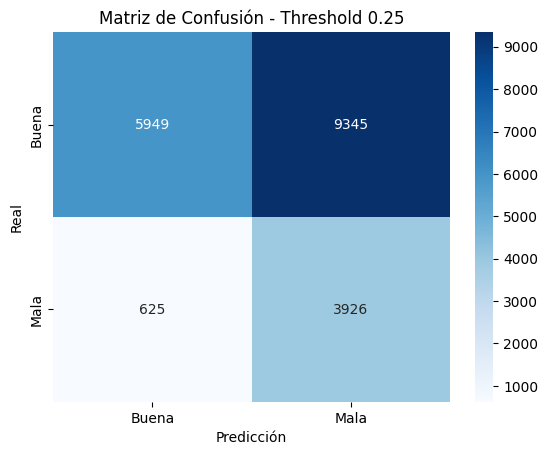

In [ ]:

# =========================
# Preparación de features y target
# =========================
X = df_encoded[num_features + cat_features].copy()
y = 1 - df_encoded['review_binary']  # Clase minoritaria = 1 (malas reviews)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Distribución original (train):", np.bincount(y_train))

# =========================
# Limpieza y codificación
# =========================
# Numéricas: rellenar NaNs y clip percentiles
lower, upper = 0.01, 0.98
for col in num_features:
    median = X_train[col].median()
    X_train[col] = X_train[col].fillna(median)
    X_test[col] = X_test[col].fillna(median)
    low_val = X_train[col].quantile(lower)
    high_val = X_train[col].quantile(upper)
    X_train[col] = X_train[col].clip(low_val, high_val)
    X_test[col] = X_test[col].clip(low_val, high_val)

# Escalado
scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

# Categóricas: One-Hot Encoding
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = ohe.fit_transform(X_train[cat_features])
X_test_cat = ohe.transform(X_test[cat_features])


# Concatenar numéricas + categóricas
X_train_nn = np.hstack([X_train[num_features].values, X_train_cat])
X_test_nn = np.hstack([X_test[num_features].values, X_test_cat])

# =========================
# Balanceo con SMOTE
# =========================
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_nn, y_train)
print("Distribución balanceada (train_res):", np.bincount(y_train_res))

# =========================
# Construcción y entrenamiento de la red neuronal
# =========================
input_dim = X_train_res.shape[1]

model_nn = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model_nn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['AUC', 'Precision', 'Recall']
)

history = model_nn.fit(
    X_train_res, y_train_res,
    validation_split=0.2,
    epochs=50,
    batch_size=256,
    class_weight={0:1, 1: X_train_res.shape[0]/X_train_res[y_train_res==1].shape[0]},
    verbose=2
)

# =========================
# Predicciones y threshold manual
# =========================
y_pred_proba = model_nn.predict(X_test_nn).flatten()
manual_thresh = 0.25
y_pred_bin = (y_pred_proba >= manual_thresh).astype(int)

# =========================
# Evaluación
# =========================
print(f"\n Classification Report (Threshold = {manual_thresh}):")
print(classification_report(y_test, y_pred_bin, digits=3))
print(" ROC AUC:", roc_auc_score(y_test, y_pred_proba))

cm = confusion_matrix(y_test, y_pred_bin)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Buena','Mala'], yticklabels=['Buena','Mala'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title(f'Matriz de Confusión - Threshold {manual_thresh}')
plt.show()


Distribución original (train): [61176 18203]
Distribución balanceada (train_res): [61176 61176]
Epoch 1/50
383/383 - 5s - 13ms/step - auc: 0.7432 - loss: 0.8223 - precision: 0.5940 - recall: 0.8430 - val_auc: 0.7876 - val_loss: 0.5832 - val_precision: 0.6426 - val_recall: 0.8169
Epoch 2/50
383/383 - 3s - 7ms/step - auc: 0.7782 - loss: 0.7788 - precision: 0.6246 - recall: 0.8341 - val_auc: 0.7963 - val_loss: 0.5891 - val_precision: 0.6217 - val_recall: 0.8647
Epoch 3/50
383/383 - 2s - 6ms/step - auc: 0.7882 - loss: 0.7649 - precision: 0.6311 - recall: 0.8418 - val_auc: 0.8044 - val_loss: 0.5737 - val_precision: 0.6344 - val_recall: 0.8569
Epoch 4/50
383/383 - 3s - 8ms/step - auc: 0.7984 - loss: 0.7517 - precision: 0.6378 - recall: 0.8544 - val_auc: 0.8130 - val_loss: 0.5651 - val_precision: 0.6440 - val_recall: 0.8654
Epoch 5/50
383/383 - 3s - 8ms/step - auc: 0.8072 - loss: 0.7394 - precision: 0.6436 - recall: 0.8600 - val_auc: 0.8231 - val_loss: 0.5658 - val_precision: 0.6394 - val_rec

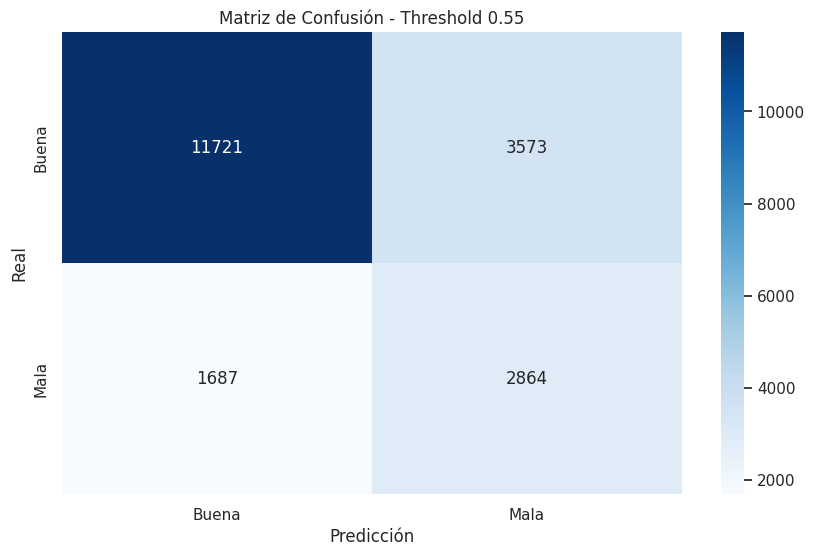

In [ ]:
# =========================
# Preparación de features y target
# =========================
X = df_encoded[num_features + cat_features].copy()
y = 1 - df_encoded['review_binary']  # Clase minoritaria = 1 (malas reviews)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Distribución original (train):", np.bincount(y_train))

# =========================
# Limpieza y codificación
# =========================
# Numéricas: rellenar NaNs y clip percentiles
lower, upper = 0.01, 0.98
for col in num_features:
    median = X_train[col].median()
    X_train[col] = X_train[col].fillna(median)
    X_test[col] = X_test[col].fillna(median)
    low_val = X_train[col].quantile(lower)
    high_val = X_train[col].quantile(upper)
    X_train[col] = X_train[col].clip(low_val, high_val)
    X_test[col] = X_test[col].clip(low_val, high_val)

# Escalado
scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

# Categóricas: One-Hot Encoding
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = ohe.fit_transform(X_train[cat_features])
X_test_cat = ohe.transform(X_test[cat_features])


# Concatenar numéricas + categóricas
X_train_nn = np.hstack([X_train[num_features].values, X_train_cat])
X_test_nn = np.hstack([X_test[num_features].values, X_test_cat])

# =========================
# Balanceo con SMOTE
# =========================
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_nn, y_train)
print("Distribución balanceada (train_res):", np.bincount(y_train_res))

# =========================
# Construcción y entrenamiento de la red neuronal
# =========================
input_dim = X_train_res.shape[1]

model_nn = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model_nn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[AUC(name='auc'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

# =========================
# Split explícito de validación
# =========================
X_train_res_final, X_val_res, y_train_res_final, y_val_res = train_test_split(
    X_train_res, y_train_res, test_size=0.2, stratify=y_train_res, random_state=42
)

history = model_nn.fit(
    X_train_res_final, y_train_res_final,
    validation_data=(X_val_res, y_val_res),
    epochs=50,
    batch_size=256,
    class_weight={0:1, 1: X_train_res.shape[0]/X_train_res[y_train_res==1].shape[0]},
    verbose=2
)

print("Distribución validación:", np.bincount(y_val_res))

# =========================
# Predicciones y threshold manual
# =========================
y_pred_proba = model_nn.predict(X_test_nn).flatten()
manual_thresh = 0.55
y_pred_bin = (y_pred_proba >= manual_thresh).astype(int)

# =========================
# Evaluación
# =========================
print(f"\n Classification Report (Threshold = {manual_thresh}):")
print(classification_report(y_test, y_pred_bin, digits=3))
print(" ROC AUC:", roc_auc_score(y_test, y_pred_proba))

cm = confusion_matrix(y_test, y_pred_bin)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Buena','Mala'], yticklabels=['Buena','Mala'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title(f'Matriz de Confusión - Threshold {manual_thresh}')
plt.show()


In [ ]:
from sklearn.metrics import f1_score, precision_recall_curve
import numpy as np

# Probabilidades predichas
y_pred_proba = model_nn.predict(X_test_nn).flatten()

# Calcular precision-recall y thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Calcular F1 para cada threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)

# Mejor threshold que maximiza F1
best_thresh = thresholds[f1_scores.argmax()]
print(f"✅ Mejor threshold (max F1): {best_thresh:.3f}")

# Predicciones binarias usando el threshold optimizado
y_pred_bin = (y_pred_proba >= best_thresh).astype(int)


621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ Mejor threshold (max F1): 0.644


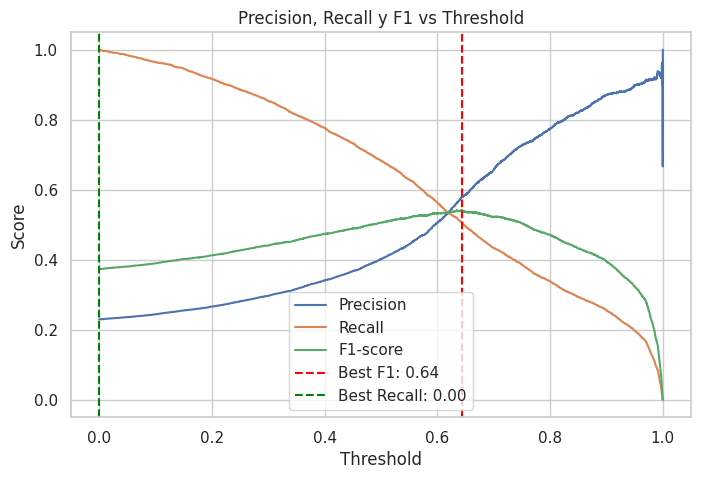

✅ Mejor Threshold (F1): 0.644


In [ ]:
# Calcular precision, recall y thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Alinear longitudes (precision_recall_curve devuelve un elemento más en precision y recall)
precisions = precisions[:-1]
recalls = recalls[:-1]

# Calcular F1 para cada threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)

# Threshold que maximiza F1
best_f1_thresh = thresholds[f1_scores.argmax()]
# Threshold que maximiza recall
best_recall_thresh = thresholds[recalls.argmax()]

plt.figure(figsize=(8,5))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1-score')

# Líneas de referencia
plt.axvline(best_f1_thresh, color='red', linestyle='--', label=f'Best F1: {best_f1_thresh:.2f}')
plt.axvline(best_recall_thresh, color='green', linestyle='--', label=f'Best Recall: {best_recall_thresh:.2f}')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall y F1 vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

print(f"✅ Mejor Threshold (F1): {best_f1_thresh:.3f}")


621/621 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


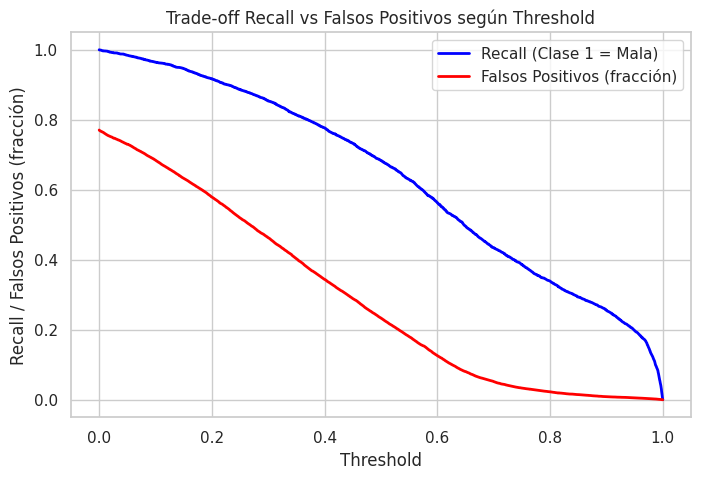

In [ ]:
# Calcular probabilidades predichas
y_pred_proba = model_nn.predict(X_test_nn).flatten()  # o tu modelo elegido

# Calcular precisión, recall y thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Ajustar longitudes para alinear thresholds
precisions = precisions[:-1]
recalls = recalls[:-1]

# Calcular falsos positivos aproximados por threshold
# FP = Predicted Positive - True Positive
pred_pos = np.array([((y_pred_proba >= t).astype(int)).sum() for t in thresholds])
true_pos = recalls * y_test.sum()
false_pos = pred_pos - true_pos

# Graficar
plt.figure(figsize=(8,5))
plt.plot(thresholds, recalls, label='Recall (Clase 1 = Mala)', color='blue', linewidth=2)
plt.plot(thresholds, false_pos / len(y_test), label='Falsos Positivos (fracción)', color='red', linewidth=2)
plt.xlabel('Threshold')
plt.ylabel('Recall / Falsos Positivos (fracción)')
plt.title('Trade-off Recall vs Falsos Positivos según Threshold')
plt.legend()
plt.grid(True)
plt.show()

## Azul Recall de la clase minoritaria
## Roja porcion de falsos positivo en el dataset


# Arquitectura de la Red Neuronal (Modelo Actual)

La arquitectura utilizada corresponde a un **Multilayer Perceptron (MLP)** para clasificación binaria.  
Este modelo toma como entrada todas las features numéricas y categóricas codificadas, y devuelve una probabilidad entre 0 y 1.

---

## Estructura de capas

| Nº | Capa             | Tipo           | Neuronas | Activación | Dropout | Salida        |
|----|-----------------|---------------|----------|------------|---------|---------------|
| 1  | Input            | Entrada        | —        | —          | —       | `(input_dim,)`|
| 2  | Dense 1          | Oculta         | 128      | ReLU       | —       | `(128,)`      |
| 3  | Dropout 1        | Regularización | —        | —          | 0.3     | `(128,)`      |
| 4  | Dense 2          | Oculta         | 64       | ReLU       | —       | `(64,)`       |
| 5  | Dropout 2        | Regularización | —        | —          | 0.3     | `(64,)`       |
| 6  | Dense (Output)   | Salida         | 1        | Sigmoid    | —       | `(1,)`        |

---

## Compilación del modelo

- **Optimizador:** Adam  
- **Pérdida:** binary_crossentropy  
- **Métricas:** AUC, Precisión, Recall  

---

## Entrenamiento

- Épocas: 50  
- Batch size: 256  
- Validación: 20 % de los datos de entrenamiento  
- Balanceo: SMOTE aplicado sobre la clase minoritaria  
- Threshold manual: 0.31 para convertir probabilidades en predicciones binarias

---

## Observaciones

- Las capas ocultas con activación **ReLU** permiten capturar relaciones no lineales entre las variables.  
- El uso de **Dropout (0.3)** ayuda a prevenir overfitting.  
- La activación **Sigmoid** en la capa de salida produce probabilidades de pertenencia a la clase positiva.  
- La métrica **AUC** mide la capacidad discriminativa del modelo incluso con clases desbalanceadas.  
- **Precision** y **Recall** permiten evaluar la calidad de la clasificación sobre la clase minoritaria.

✅ Esta arquitectura es simple pero efectiva para tareas de clasificación binaria con un número moderado de features.


In [ ]:
# =========================
# Red neuronal más compleja
# =========================
from tensorflow.keras import layers, models
import tensorflow as tf

input_dim = X_train_res.shape[1]

model_nn_complex = models.Sequential([
    layers.Input(shape=(input_dim,)),

    # Primera capa densa + BatchNorm + Dropout
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    # Segunda capa densa + BatchNorm + Dropout
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Tercera capa densa
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    # Capa de salida
    layers.Dense(1, activation='sigmoid')
])

# Compilación
model_nn_complex.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

# Entrenamiento
history_complex = model_nn_complex.fit(
    X_train_res, y_train_res,
    validation_split=0.2,
    epochs=50,
    batch_size=256,
    class_weight={0:1, 1: X_train_res.shape[0]/X_train_res[y_train_res==1].shape[0]},
    verbose=2
)


Epoch 1/50
383/383 - 10s - 26ms/step - auc: 0.7286 - loss: 0.8462 - precision: 0.5394 - recall: 0.6765 - val_auc: 0.0000e+00 - val_loss: 0.5026 - val_precision: 1.0000 - val_recall: 0.6953
Epoch 2/50
383/383 - 5s - 14ms/step - auc: 0.7709 - loss: 0.7737 - precision: 0.5846 - recall: 0.6894 - val_auc: 0.0000e+00 - val_loss: 0.4892 - val_precision: 1.0000 - val_recall: 0.7031
Epoch 3/50
383/383 - 4s - 11ms/step - auc: 0.7814 - loss: 0.7592 - precision: 0.5955 - recall: 0.6975 - val_auc: 0.0000e+00 - val_loss: 0.4760 - val_precision: 1.0000 - val_recall: 0.7057
Epoch 4/50
383/383 - 4s - 11ms/step - auc: 0.7863 - loss: 0.7517 - precision: 0.6028 - recall: 0.6964 - val_auc: 0.0000e+00 - val_loss: 0.4440 - val_precision: 1.0000 - val_recall: 0.7462
Epoch 5/50
383/383 - 5s - 14ms/step - auc: 0.7912 - loss: 0.7447 - precision: 0.6070 - recall: 0.6995 - val_auc: 0.0000e+00 - val_loss: 0.4332 - val_precision: 1.0000 - val_recall: 0.7637
Epoch 6/50
383/383 - 4s - 11ms/step - auc: 0.7970 - loss: 0

621/621 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

📊 Classification Report (Threshold = 0.3):
              precision    recall  f1-score   support

           0      0.887     0.622     0.731     15294
           1      0.366     0.734     0.489      4551

    accuracy                          0.648     19845
   macro avg      0.627     0.678     0.610     19845
weighted avg      0.768     0.648     0.676     19845

🔥 ROC AUC: 0.760577332348663


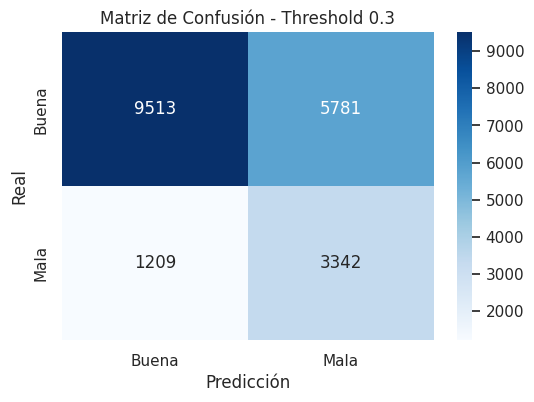

In [ ]:
# =========================
# Predicciones y threshold manual
# =========================
y_pred_proba_complex = model_nn_complex.predict(X_test_nn).flatten()

# Elegimos un threshold, por ejemplo 0.644 (F1 óptimo) o cualquier otro que quieras probar
manual_thresh = 0.3
y_pred_bin_complex = (y_pred_proba_complex >= manual_thresh).astype(int)

# =========================
# Evaluación
# =========================
print(f"\n📊 Classification Report (Threshold = {manual_thresh}):")
print(classification_report(y_test, y_pred_bin_complex, digits=3))
print("🔥 ROC AUC:", roc_auc_score(y_test, y_pred_proba_complex))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_bin_complex)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Buena','Mala'], yticklabels=['Buena','Mala'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title(f'Matriz de Confusión - Threshold {manual_thresh}')
plt.show()

# Arquitectura de la Red Neuronal (Modelo Complejo)

**Entrada:**
- 25 features numéricas y codificadas (tras One-Hot y StandardScaler)
- Dimensión de entrada: 25 (ajustable según encoding)

**Capas ocultas:**
1. **Capa densa**: 256 neuronas, activación ReLU  
   **Batch Normalization** + **Dropout 0.4**  
   _Objetivo: aprender representaciones complejas y regularizar para evitar overfitting_
2. **Capa densa**: 128 neuronas, activación ReLU  
   **Batch Normalization** + **Dropout 0.3**  
   _Objetivo: refinar patrones aprendidos y mantener estabilidad en el entrenamiento_
3. **Capa densa**: 64 neuronas, activación ReLU  
   **Batch Normalization** + **Dropout 0.2**  
   _Objetivo: compresión final de la información antes de la salida_

**Capa de salida:**
- 1 neurona, activación Sigmoid  
- Produce probabilidad de que la review sea "mala" (clase 1)

**Compilación:**
- Optimizer: Adam
- Loss: Binary Crossentropy
- Métricas: AUC, Precision, Recall
- Uso de `class_weight` para balancear la clase minoritaria

**Regularización y estabilidad:**
- Dropout progresivo (0.4 → 0.3 → 0.2) para reducir overfitting
- Batch Normalization tras cada capa densa para acelerar convergencia y mejorar estabilidad

**Notas:**
- El tamaño de las capas y Dropout se eligió considerando ~93k registros y 25 features
- Diseñada para maximizar recall sin perder demasiado F1, dado que la clase minoritaria es la más importante


In [ ]:
from sklearn.metrics import roc_curve
import plotly.graph_objects as go

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name='ROC'))
fig.add_trace(go.Scatter(x=[0,1], y=[0,1], mode='lines', line=dict(dash='dash'), showlegend=False))
fig.update_layout(title='ROC Curve Interactiva', xaxis_title='FPR', yaxis_title='TPR')
fig.show()



In [ ]:
from tensorflow.keras import Model, Input

# Crear un input explícito
inputs = Input(shape=(X_train_res.shape[1],))
x = layers.Dense(256, activation='relu')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_functional = Model(inputs=inputs, outputs=outputs)
model_functional.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC', 'Precision', 'Recall'])
_ = model_functional.fit(X_train_res, y_train_res, epochs=1, batch_size=256, verbose=0)

# Modelo de activaciones
layer_outputs = [layer.output for layer in model_functional.layers[:3]]
activation_model = Model(inputs=model_functional.input, outputs=layer_outputs)
activations = activation_model.predict(X_test_nn[:50])



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


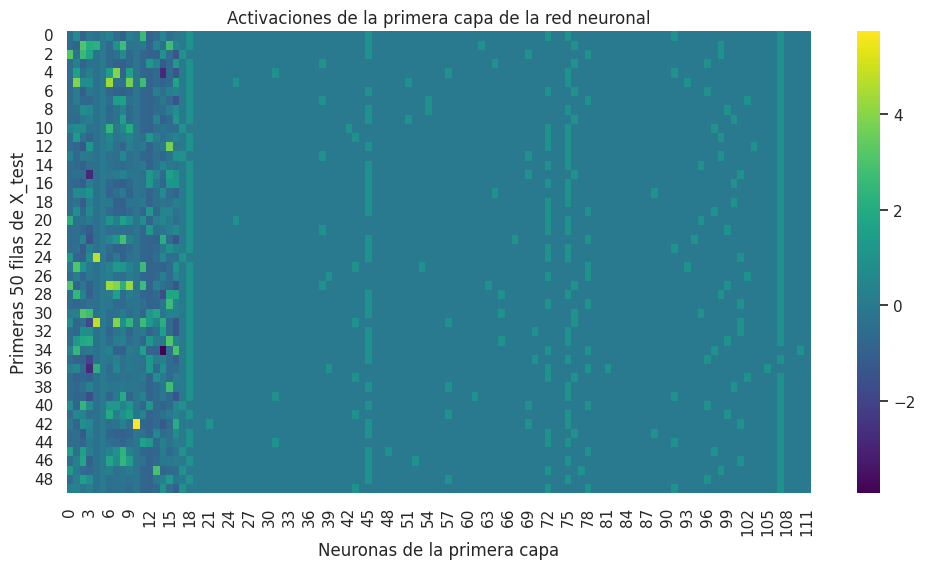

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# activations[0] = salida de la primera capa densa (256 neuronas)
first_layer_activations = activations[0]

plt.figure(figsize=(12,6))
sns.heatmap(first_layer_activations, cmap='viridis', cbar=True)
plt.xlabel("Neuronas de la primera capa")
plt.ylabel("Primeras 50 filas de X_test")
plt.title("Activaciones de la primera capa de la red neuronal")
plt.show()


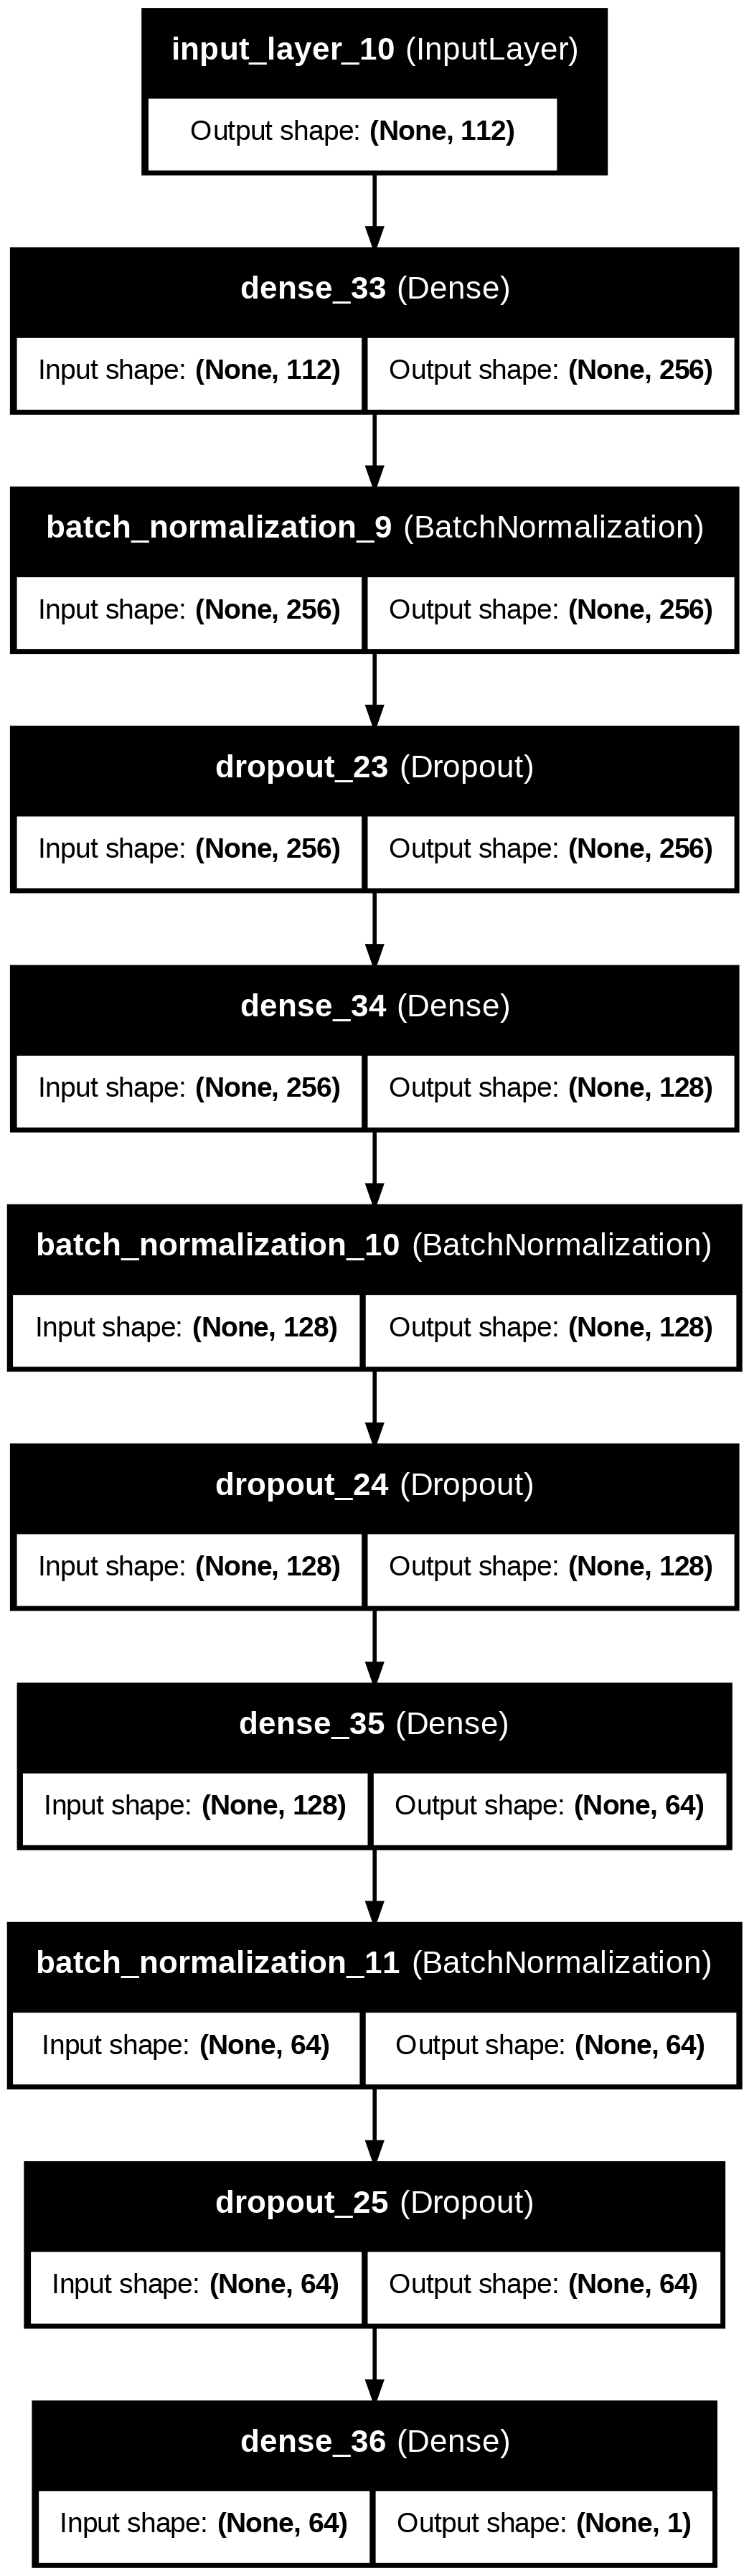

In [ ]:
from tensorflow.keras.utils import plot_model

# Para guardar un archivo PNG
plot_model(model_functional, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


In [ ]:
model_functional.save("my_model.keras")




In [ ]:
from tensorflow.keras.models import load_model

model_loaded = load_model("my_model.keras")

model_loaded.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning:

Skipping variable loading for optimizer 'rmsprop', because it has 16 variables whereas the saved optimizer has 30 variables. 



Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 112)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 256)            │        28,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,980 (558.52 KB)

 Trainable params: 71,041 (277.50 KB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 71,043 (277.52 KB)

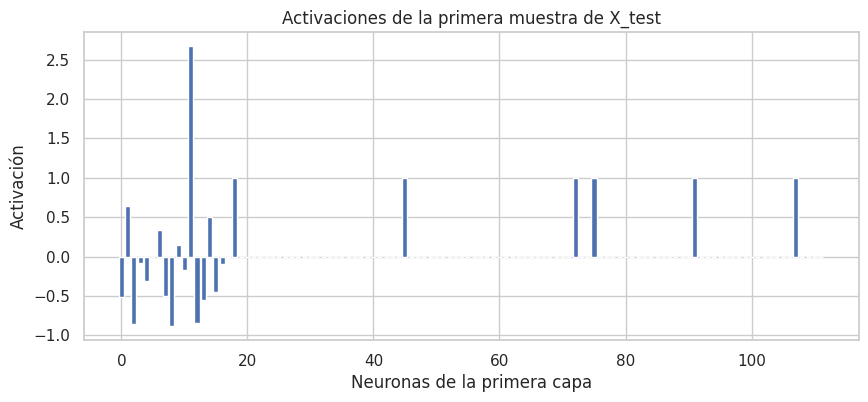

In [ ]:
plt.figure(figsize=(10,4))
plt.bar(range(first_layer_activations.shape[1]), first_layer_activations[0])
plt.xlabel("Neuronas de la primera capa")
plt.ylabel("Activación")
plt.title("Activaciones de la primera muestra de X_test")
plt.show()

# Marco teórico y Benchmarks

## Importancia de identificar reseñas negativas

* Se ha demostrado que las reseñas negativas tienen un impacto sustancial en las decisiones de compra. Por ejemplo, en un estudio se encontró que la aparición de una reseña negativa (3 estrellas o menos sobre 5) puede reducir la probabilidad de compra en un ~51 %.
[ResearchGate](https://www.researchgate.net/publication/337587666_Measuring_the_Impact_of_a_Single_Negative_Customer_Review_on_Online_Search_and_Purchase_Decisions)

* Otros estudios concluyen que las reseñas negativas “atraen más atención que las positivas” al navegar productos online, lo cual sugiere que los consumidores se fijan más en las malas experiencias.
[Frontiers](https://www.frontiersin.org/journals/psychology/articles/10.3389/fpsyg.2022.865702/full)


* Desde la perspectiva del negocio, esto implica que ***no detectar una mala reseña*** (o no anticipar una mala reseña antes de que ocurra) puede traducirse en pérdidas de reputación, menores conversiones, y mayor coste de atender queja o recuperación. Por ejemplo, un informe afirmó que una estrella menos en la valoración de un negocio puede repercutir en una caída del 5-9 % en ingresos.
[Norton Shopping Guarantee Blog](https://blog.norton.buysafe.com/the-impact-of-negative-reviews?utm_source)

* Por lo tanto, desarrollar un modelo que identifique de forma temprana las órdenes con alta probabilidad de mala reseña tiene un claro valor estratégico para priorizar acciones preventivas, asignar recursos de atención al cliente, y mejorar la satisfacción general.

## Relevancia metodológica y datos desbalanceados

En clasificación con clases desbalanceadas (como “malas reseñas” como clase minoritaria), la métrica de recall para la clase minoritaria (es decir, cuántas de las malas reseñas se detectan) es particularmente relevante. Dentro de las métricas se enfatiza que el recall es clave cuando el coste de no detectar una instancia de la clase de interés es alto
[Focal AI](https://www.getfocal.co/post/top-7-metrics-to-evaluate-sentiment-analysis-models?utm_source)
. La revisión académica (“[Survey on deep learning with class imbalance](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0192-5?utm_source=chatgpt.com)”) señala que en tareas con desbalance, los modelos tienden a ignorar la clase minoritaria y que aplicar técnicas de balanceo, pesos, umbrales, etc., es indispensable para lograr buen rendimiento.


Por tanto, el enfoque de aplicar balanceo (SMOTE por ejemplo) y optimización de umbral está plenamente justificado metodológicamente.

## Benchmarks y métricas sugeridas

Aunque es difícil encontrar exactamente el mismo problema (orden → reseña mala/buena) con métricas publicadas, encontramos algunas referencias que dan pautas útiles para fijar objetivos realistas:

En una tarea financiera de predicción de crisis (clase minoritaria ~12 %), se reportó un F1 ≈ 0.63 tras técnicas de resampling con XGBoost como clasificador base.
[MDPI](https://www.mdpi.com/2227-7390/13/13/2186?utm_source)

En cuanto a impacto de reseñas negativas en e-commerce, se constató la fuerte relevancia de las mismas, lo que refuerza la necesidad de una buena sensibilidad (recall) sobre ese tipo de eventos.
[SAGE Journals](https://journals.sagepub.com/doi/10.1177/00222437231190874?utm_source)

